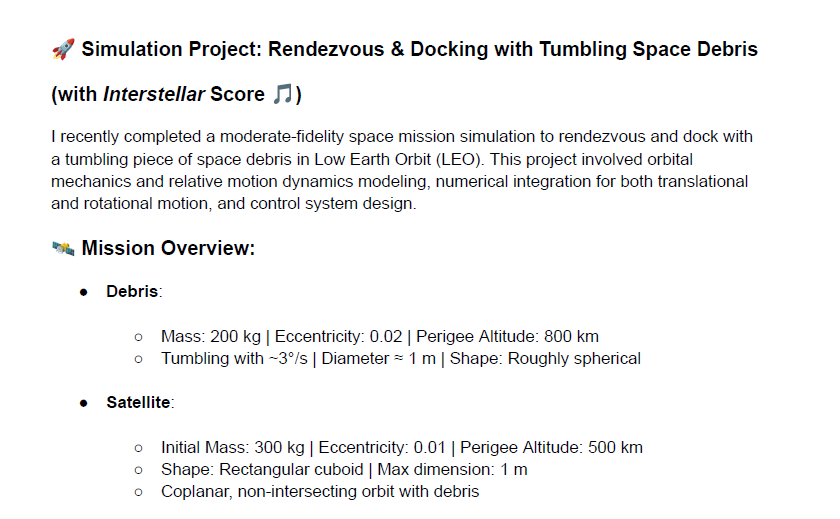

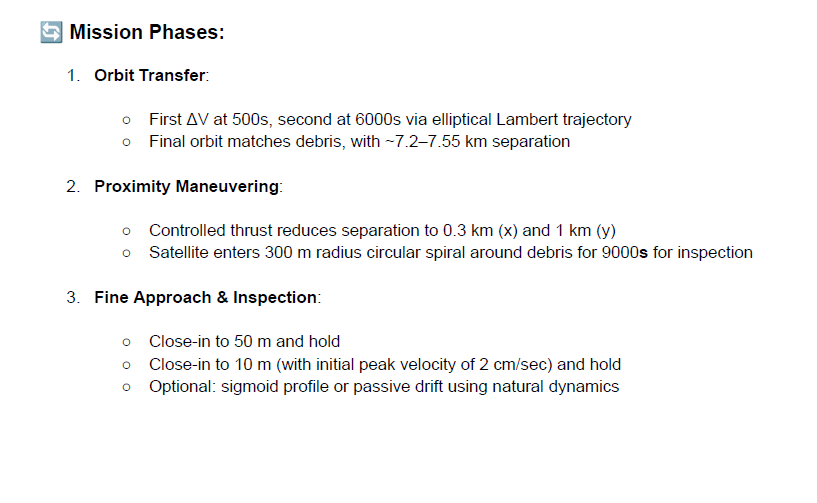

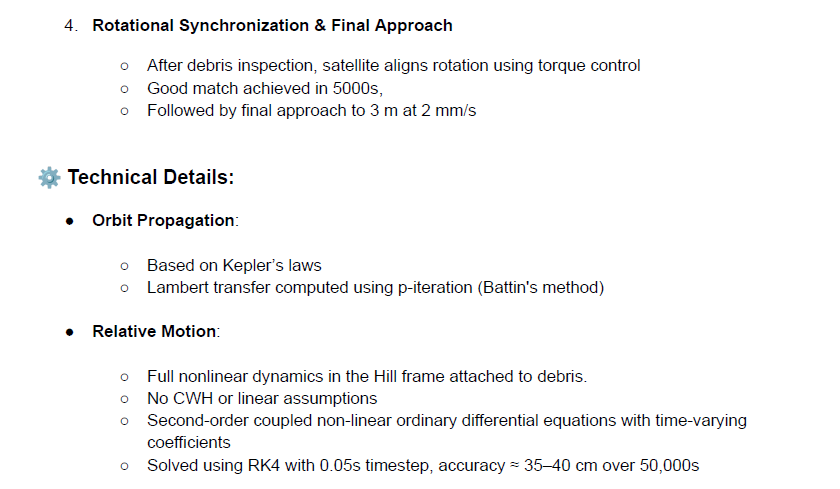

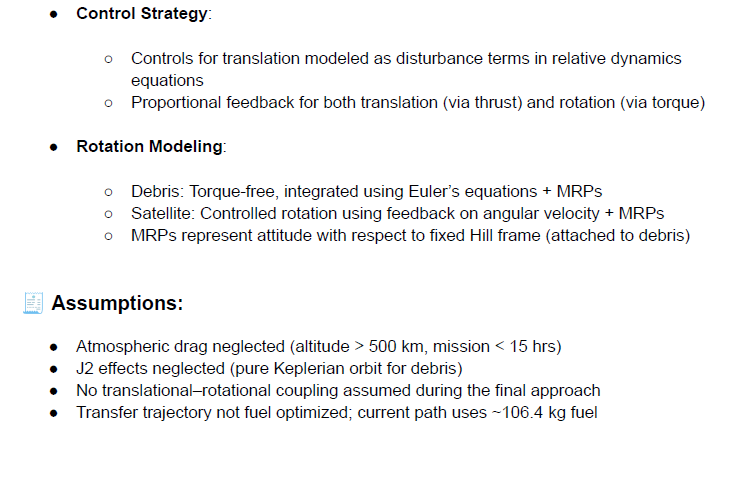

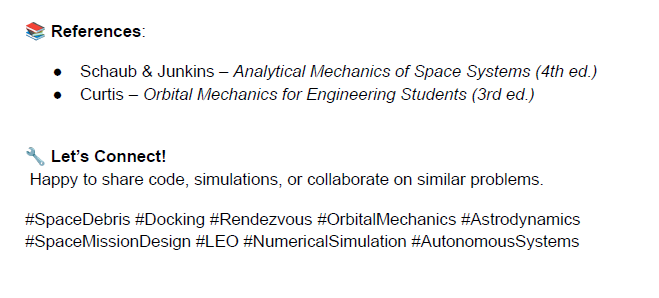

In [658]:
%matplotlib notebook

In [659]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display, clear_output
#import time
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import proj3d
import ffmpeg
from IPython.display import Video
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [660]:
# The radius of the Earth is 6,378 km

R_earth=6378*1000

In [661]:
# Mass of the earth is 

M_earth=5.97219*10**24

In [662]:
# Gravitational constant G

G=6.6743*10**-11

In [663]:
# Gravitational parameter of the Earth = G * m_Earth

mu=G*M_earth
mu

398601877170000.0

In [664]:
# Orbit elements of satellite

Omega_s= np.radians(30)
i_s= np.radians(60)
omega_s= np.radians(130)
e_s=0.01
f0_s=np.radians(235) # initial true anamoly of satellite

In [665]:
# Orbit elements of target (debris)

Omega_t= np.radians(30)
i_t= np.radians(60)
omega_t= np.radians(250)
e_t=0.02
f0_t=np.radians(80) # initial true anamoly of target

In [666]:
# Let the minimum distance of satellite from the surface of earth be 500 km 
# Hence perigee of satellite is R_earth+500 
# Thus, r_perigee=a(1-e)
# Thus a_s= r_perigee/(1-e)

h_minimum_s=500*1000
r_perigee_s=R_earth+h_minimum_s

# semi major axis of satellite 
a_s=(r_perigee_s)/(1-e_s)

# maximum distance of the satellite from the surface of earth 

h_maximum_s=a_s*(1+e_s)-R_earth

print('minimum distance of satellite from the surface of earth is', h_minimum_s, 'meters' )
print('maximum distance of satellite from the surface of earth is', h_maximum_s, 'meters' )


minimum distance of satellite from the surface of earth is 500000 meters
maximum distance of satellite from the surface of earth is 638949.4949494954 meters


In [667]:
a_s*(1-0.01**2)

6946780.0

In [668]:
# Let the minimum distance of target from the surface of earth be 800 km 
# Hence perigee of debris is R_earth+800
# Thus, r_perigee=a(1-e)
# Thus a_s= r_perigee/(1-e)

h_minimum_t=800*1000
r_perigee_t=R_earth+h_minimum_t

# semi major axis of target 
a_t=(r_perigee_t)/(1-e_t)

# maximum distance of the target from the surface of earth 

h_maximum_t=a_t*(1+e_t)-R_earth

print('minimum distance of target from the surface of earth is', h_minimum_t, 'meters' )
print('maximum distance of target from the surface of earth is', h_maximum_t, 'meters' )

minimum distance of target from the surface of earth is 800000 meters
maximum distance of target from the surface of earth is 1092979.5918367356 meters


In [669]:
a_t

7324489.795918368

In [670]:
# satellite period calculation

T_s=2*np.pi*np.sqrt(a_s**3/mu)

print('period of the satellite is', T_s, 'seconds')

period of the satellite is 5763.027127440836 seconds


In [671]:
# target period calculation

T_t=2*np.pi*np.sqrt(a_t**3/mu)

print('period of the target is', T_t, 'seconds')

period of the target is 6238.443785236095 seconds


In [672]:
# Orbit_propogation of satellite

# specific angular momentum

h_s=np.sqrt(mu*a_s*(1-e_s**2))

# Initial mean anamoly calculation
    
E0=2 * np.arctan(np.sqrt((1 - e_s) / (1 + e_s)) * np.tan(f0_s / 2))
M0=E0-e_s*np.sin(E0)

# Mean motion calculation 

n_s = np.sqrt(mu / a_s**3)

# Kepler's equation

def kepler_solve(M, e, tol=1e-6):
    E = M 
    for _ in range(100):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E

# inertial position and inertial velocity of satellite as function of time


f_dot_satellite=[]
DCM_in_to_hill_satellite=[]
r_inertial_satellite=[]
v_inertial_satellite=[]
f_satellite=[]
time_propogation=[]

t_final=501

for t in range (t_final):
    M = M0 + n_s * t
    E=kepler_solve(M, e_s)
    
    f_s = 2 * np.arctan(np.sqrt((1 + e_s) / (1 - e_s)) * np.tan(E / 2))
    f_satellite.append(f_s)
    
    r_s=(a_s * (1 - e_s**2)) / (1 + e_s * np.cos(f_s))
    v_r_s=(mu/h_s)*e_s*np.sin(f_s)
    v_t_s=(mu/h_s)*(1+e_s*np.cos(f_s))
    f_dot_s=h_s/r_s**2
    f_dot_satellite.append(f_dot_s)
    
    theta1=Omega_s
    theta2=i_s
    theta3=omega_s+f_s
  
    c1, s1 = np.cos(theta1), np.sin(theta1)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    c3, s3 = np.cos(theta3), np.sin(theta3)
    
    DCM_hill_to_inertial= np.array([
        [ c1 * c3 - s1 * c2 * s3,  -c1 * s3 - s1 * c2 * c3,  s1 * s2],
        [ s1 * c3 + c1 * c2 * s3,  -s1 * s3 + c1 * c2 * c3, -c1 * s2],
        [ s2 * s3,                  s2 * c3,                c2]])
    
    DCM_inertial_to_hill=np.linalg.inv(DCM_hill_to_inertial)
    DCM_in_to_hill_satellite.append(DCM_inertial_to_hill)
    
    r_in_s=DCM_hill_to_inertial @ np.array([[r_s],[0],[0]])
    r_inertial_satellite.append(r_in_s)
    
    v_in_s=DCM_hill_to_inertial @ np.array([[v_r_s],[v_t_s],[0]])
    v_inertial_satellite.append(v_in_s)
    
    time_propogation.append(t)
    
    
    
r_inertial_satellite=np.array(r_inertial_satellite)
v_inertial_satellite=np.array(v_inertial_satellite)
f_satellite=np.array(f_satellite)
f_dot_satellite=np.array(f_dot_satellite)
time_propogation=np.array(time_propogation)

In [673]:
# extracting inertial coordinates of satellite

x_inertial_s = r_inertial_satellite[:, 0, 0]  
y_inertial_s = r_inertial_satellite[:, 1, 0]  
z_inertial_s = r_inertial_satellite[:, 2, 0] 

In [674]:
r_inertial_satellite[500]

array([[3846165.93144614],
       [4581507.37103557],
       [3541383.65275076]])

In [675]:
v_inertial_satellite[500]

array([[-5428.43531305],
       [  374.45750223],
       [ 5262.84913725]])

In [676]:
omega_s+f_satellite[500]

0.6288868716433942

In [677]:
# Orbit_propogation of target

# specific angular momentum

h_t=np.sqrt(mu*a_t*(1-e_t**2))

# Initial mean anamoly calculation
    
E0=2 * np.arctan(np.sqrt((1 - e_t) / (1 + e_t)) * np.tan(f0_t / 2))
M0=E0-e_t*np.sin(E0)

# Mean motion calculation 

n_t = np.sqrt(mu / a_t**3)

# Kepler's equation

def kepler_solve(M, e, tol=1e-6):
    E = M 
    for _ in range(100):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E

# inertial position and inertial velocity of target as function of time


f_dot_target=[]
DCM_in_to_hill_target=[]
r_inertial_target=[]
v_inertial_target=[]
f_target=[]
time_propogation=[]

t_final=25000

for t in range (t_final):
    M = M0 + n_t * t
    E=kepler_solve(M, e_t)
    
    f_t = 2 * np.arctan(np.sqrt((1 + e_t) / (1 - e_t)) * np.tan(E / 2))
    f_target.append(f_t)
    
    r_t=(a_t * (1 - e_t**2)) / (1 + e_t * np.cos(f_t))
    v_r_t=(mu/h_t)*e_t*np.sin(f_t)
    v_t_t=(mu/h_t)*(1+e_t*np.cos(f_t))
    f_dot_t=h_t/r_t**2
    f_dot_target.append(f_dot_t)
    
    theta1=Omega_t
    theta2=i_t
    theta3=omega_t+f_t
  
    c1, s1 = np.cos(theta1), np.sin(theta1)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    c3, s3 = np.cos(theta3), np.sin(theta3)
    
    DCM_hill_to_inertial= np.array([
        [ c1 * c3 - s1 * c2 * s3,  -c1 * s3 - s1 * c2 * c3,  s1 * s2],
        [ s1 * c3 + c1 * c2 * s3,  -s1 * s3 + c1 * c2 * c3, -c1 * s2],
        [ s2 * s3,                  s2 * c3,                c2]])
    
    DCM_inertial_to_hill=np.linalg.inv(DCM_hill_to_inertial)
    DCM_in_to_hill_target.append(DCM_inertial_to_hill)
    
    r_in_t=DCM_hill_to_inertial @ np.array([[r_t],[0],[0]])
    r_inertial_target.append(r_in_t)
    
    v_in_t=DCM_hill_to_inertial @ np.array([[v_r_t],[v_t_t],[0]])
    v_inertial_target.append(v_in_t)
    
    time_propogation.append(t)
    
    
    
r_inertial_target=np.array(r_inertial_target)
v_inertial_target=np.array(v_inertial_target)
f_target=np.array(f_target)
f_dot_target=np.array(f_dot_target)
time_propogation=np.array(time_propogation)
DCM_in_to_hill_target=np.array(DCM_in_to_hill_target)

In [678]:
# extracting inertial coordinates of target

x_inertial_t = r_inertial_target[:, 0, 0]  
y_inertial_t = r_inertial_target[:, 1, 0]  
z_inertial_t = r_inertial_target[:, 2, 0] 

In [679]:
r_inertial_target[6001]

array([[ 5792688.39323148],
       [  438438.53699236],
       [-4358957.49925718]])

In [680]:
v_inertial_target[6001]

array([[3231.30368392],
       [4907.52779814],
       [4562.90061959]])

In [681]:
Rc_vec=np.linalg.norm(r_inertial_target, axis=1).flatten()
Rc_vec[6300]

7305209.738844398

In [682]:
r_inertial_target[6300]

array([[ 6478235.26631141],
       [ 1863218.8941628 ],
       [-2815487.97107373]])

In [683]:
# Let the orbit transfer of satellite start at 500 seconds 
# Let the orbit transfer of satellite end at 6000 seconds
# The satellite crosses the orbit of debris at exactly 6000 seconds 
# The position at which the satellite crosses the orbit of debris at 6000 seconds 
# is corresponding to the position of debris in ellipse at 6001 seconds


# Position of debris at 6000 seconds is 

r_t_6000=r_inertial_target[6000]

print ('position of debris at 6000 seconds is',r_t_6000 )

# The position of satellite at 6000 seconds is 

r_s_6000=r_inertial_target[6001]

print ('position of satellite at 6000 seconds is',r_s_6000 )

# The relative position of satellite with respect to debris at 6000 seconds 

rel_pos_6000 = r_s_6000- r_t_6000

print ('relative position of satellite with respect to debris at 6000 seconds is', rel_pos_6000)

# The distance of the satellite from debris at 6000 seconds 

distance_6000=np.linalg.norm(rel_pos_6000)

print ('The distance of the satellite from debris at 6000 seconds  is', distance_6000)

# The position of satellite at 500 seconds is

r_s_500=r_inertial_satellite[500]  

print ('The position of satellite at 500 seconds is', r_s_500)


position of debris at 6000 seconds is [[ 5789454.07648562]
 [  433530.78194942]
 [-4363518.13135578]]
position of satellite at 6000 seconds is [[ 5792688.39323148]
 [  438438.53699236]
 [-4358957.49925718]]
relative position of satellite with respect to debris at 6000 seconds is [[3234.31674587]
 [4907.75504294]
 [4560.6320986 ]]
The distance of the satellite from debris at 6000 seconds  is 7439.504655071336
The position of satellite at 500 seconds is [[3846165.93144614]
 [4581507.37103557]
 [3541383.65275076]]


In [684]:
# The p-iteration method (Lambert problem)

r1 = r_s_500
r2 = r_s_6000
delta_t=6000-500

print(r1)
print("-" * 30)
print(r2)
print("-" * 30)
print(delta_t)

[[3846165.93144614]
 [4581507.37103557]
 [3541383.65275076]]
------------------------------
[[ 5792688.39323148]
 [  438438.53699236]
 [-4358957.49925718]]
------------------------------
5500


In [685]:
r1_norm=np.linalg.norm(r1)
r2_norm=np.linalg.norm(r2)
delta_f=2*np.pi-np.arccos(np.dot(r1.flatten(), r2.flatten())/(r1_norm*r2_norm))
delta_f

4.888621303950637

In [686]:
# lambert solver

def p_iteration(p):
    
    r1_norm=np.linalg.norm(r1)
    r2_norm=np.linalg.norm(r2)
    
    delta_f=2*np.pi-np.arccos(np.dot(r1.flatten(), r2.flatten())/(r1_norm*r2_norm))
    
    F=1-(r2_norm/p)*(1-np.cos(delta_f))
    F_dot=((mu/p)**0.5)*np.tan(delta_f/2)*(((1-np.cos(delta_f))/(p))-(1/r1_norm)-(1/r2_norm))
    G=((r1_norm*r2_norm)/((mu*p)**0.5))*np.sin(delta_f)
    G_dot=1-(r1_norm/p)*(1-np.cos(delta_f))
    
    r1_dot=(1/G)*(r2-F*r1)
    r2_dot=(1/G)*(-r1+G_dot*r2)
    
    v1_squared=(1/G**2)*(F**2*r1_norm**2+r2_norm**2-2*r1_norm*r2_norm*F*np.cos(delta_f))
    
    k=r1_norm*r2_norm*(1-np.cos(delta_f))
    l=r1_norm+r2_norm
    m=r1_norm*r2_norm*(1+np.cos(delta_f))
    
    a=(m*k*p)/(((2*m-l**2)*p**2)+(2*k*l*p)-(k**2))
    
    T=2*np.pi*np.sqrt(a**3/mu)
    
    cos_delta_E=1-(((1-F)*r1_norm)/(a))
    sin_delta_E=(-r1_norm*r2_norm*F_dot)/(np.sqrt(mu*a))
    
    delta_E=np.arctan(sin_delta_E/cos_delta_E)
    
    delta_t_guess=G+(np.sqrt(a**3/mu))*(delta_E-sin_delta_E)+T
    
    g_p=delta_t_guess-delta_t
    
    return g_p,a,delta_f,r1_dot,r2_dot



<IPython.core.display.Javascript object>


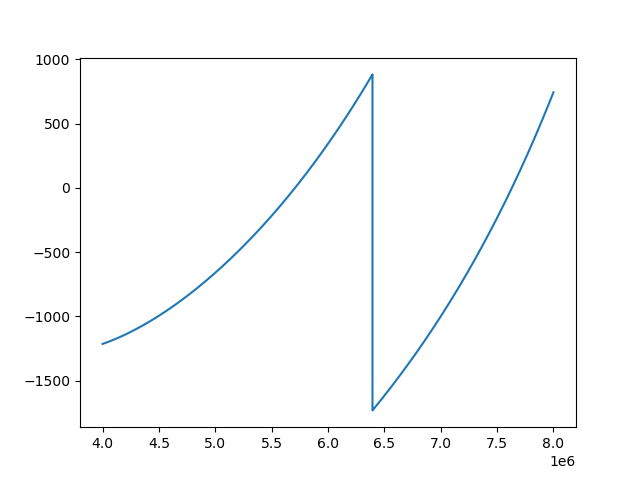

In [687]:
import matplotlib.pyplot as plt
x=[]
y=[]
for p in range(4000000,8000000,100):
    y.append(p_iteration(p)[0])
    x.append(p)
    
plt.figure()
plt.plot(x,y)

In [688]:
from scipy.optimize import fsolve

def p_iteration_find(p):
    
    r1_norm=np.linalg.norm(r1)
    r2_norm=np.linalg.norm(r2)
    
    delta_f=2*np.pi-np.arccos(np.dot(r1.flatten(), r2.flatten())/(r1_norm*r2_norm))
    
    F=1-(r2_norm/p)*(1-np.cos(delta_f))
    F_dot=(np.sqrt(mu/p))*np.tan(delta_f/2)*(((1-np.cos(delta_f))/(p))-(1/r1_norm)-(1/r2_norm))
    G=((r1_norm*r2_norm)/(np.sqrt(mu*p)))*np.sin(delta_f)
    G_dot=1-(r1_norm/p)*(1-np.cos(delta_f))
    
    r1_dot=(1/G)*(r2-F*r1)
    r2_dot=(1/G)*(-r1+G_dot*r2)
    
    v1_squared=(1/G**2)*(F**2*r1_norm**2+r2_norm**2-2*r1_norm*r2_norm*F*np.cos(delta_f))
    
    k=r1_norm*r2_norm*(1-np.cos(delta_f))
    l=r1_norm+r2_norm
    m=r1_norm*r2_norm*(1+np.cos(delta_f))
    
    a=(m*k*p)/(((2*m-l**2)*p**2)+(2*k*l*p)-(k**2))
    
    T=2*np.pi*np.sqrt(a**3/mu)
    
    cos_delta_E=1-(((1-F)*r1_norm)/(a))
    sin_delta_E=(-r1_norm*r2_norm*F_dot)/(np.sqrt(mu*a))
    
    delta_E=np.arctan(sin_delta_E/cos_delta_E)
    
    delta_t_guess=G+(np.sqrt(a**3/mu))*(delta_E-sin_delta_E) + T
    
    g_p=delta_t_guess-delta_t
    
    return g_p

# Initial guess
p0 = 6500000

# Use fsolve
root = fsolve(p_iteration_find, p0)

print("Root:", root)


Root: [7630921.69333821]


In [689]:
p_iteration(7630921.69333821)

(-7.275957614183426e-12,
 7713545.578695989,
 4.888621303950637,
 array([[-5509.35166313],
        [  607.01178566],
        [ 5681.75617714]]),
 array([[2668.83151642],
        [4962.4492012 ],
        [5132.39791016]]))

In [690]:
# transfer ellipse 

p=7630921.69333821
a=7713545.578695989
e=np.sqrt(1-(p/a))

r1_norm=np.linalg.norm(r1)
r2_norm=np.linalg.norm(r2)

f1= np.arccos(((p/r1_norm)-1)/e)
f2= 2*np.pi-np.arccos(((p/r2_norm)-1)/e)
w_transfer=2*np.pi+(np.arcsin(r2.flatten()[2]/(r2_norm*np.sin(i_s))))-f2

rp=a*(1-e)


In [691]:
e

0.10349652824768735

In [692]:
f1

0.33558556607986606

In [693]:
f2

5.224206870030567

In [694]:
f2-f1

4.888621303950702

In [695]:
w_transfer

0.2933013055634639

In [696]:
f1+w_transfer

0.62888687164333

In [697]:
# Orbit_propogation of satellite in transfer ellipse

f0_s=f1
e_s=e
a_s=a
omega_s=w_transfer

# specific angular momentum

h_s=np.sqrt(mu*a_s*(1-e_s**2))

# Initial mean anamoly calculation
    
E0=2 * np.arctan(np.sqrt((1 - e_s) / (1 + e_s)) * np.tan(f0_s / 2))
M0=E0-e_s*np.sin(E0)

# Mean motion calculation 

n_s = np.sqrt(mu / a_s**3)

# Kepler's equation

def kepler_solve(M, e, tol=1e-6):
    E = M 
    for _ in range(100):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E

# inertial position and inertial velocity of satellite as function of time


f_dot_satellite=[]
DCM_in_to_hill_satellite=[]
r_inertial_satellite=[]
v_inertial_satellite=[]
f_satellite=[]
time_propogation=[]

t_final=8000

for t in range (t_final):
    M = M0 + n_s * t
    E=kepler_solve(M, e_s)
    
    f_s = 2 * np.arctan(np.sqrt((1 + e_s) / (1 - e_s)) * np.tan(E / 2))
    f_satellite.append(f_s)
    
    r_s=(a_s * (1 - e_s**2)) / (1 + e_s * np.cos(f_s))
    v_r_s=(mu/h_s)*e_s*np.sin(f_s)
    v_t_s=(mu/h_s)*(1+e_s*np.cos(f_s))
    f_dot_s=h_s/r_s**2
    f_dot_satellite.append(f_dot_s)
    
    theta1=Omega_s
    theta2=i_s
    theta3=omega_s+f_s
  
    c1, s1 = np.cos(theta1), np.sin(theta1)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    c3, s3 = np.cos(theta3), np.sin(theta3)
    
    DCM_hill_to_inertial= np.array([
        [ c1 * c3 - s1 * c2 * s3,  -c1 * s3 - s1 * c2 * c3,  s1 * s2],
        [ s1 * c3 + c1 * c2 * s3,  -s1 * s3 + c1 * c2 * c3, -c1 * s2],
        [ s2 * s3,                  s2 * c3,                c2]])
    
    DCM_inertial_to_hill=np.linalg.inv(DCM_hill_to_inertial)
    DCM_in_to_hill_satellite.append(DCM_inertial_to_hill)
    
    r_in_s=DCM_hill_to_inertial @ np.array([[r_s],[0],[0]])
    r_inertial_satellite.append(r_in_s)
    
    v_in_s=DCM_hill_to_inertial @ np.array([[v_r_s],[v_t_s],[0]])
    v_inertial_satellite.append(v_in_s)
    
    time_propogation.append(t)
    
    
    
r_inertial_satellite_transfer=np.array(r_inertial_satellite)
v_inertial_satellite_transfer=np.array(v_inertial_satellite)
f_satellite_transfer=np.array(f_satellite)
f_dot_satellite_transfer=np.array(f_dot_satellite)
time_propogation_transfer=np.array(time_propogation)

In [698]:
r_inertial_satellite_transfer[0]

array([[3846165.93144646],
       [4581507.37103555],
       [3541383.65275045]])

In [699]:
r_inertial_satellite_transfer[1]

array([[3840654.29911517],
       [4582111.66469848],
       [3547063.30686007]])

In [700]:
r_inertial_satellite_transfer[5500]

array([[ 5792688.39323136],
       [  438438.53699213],
       [-4358957.49925742]])

In [701]:
r2

array([[ 5792688.39323148],
       [  438438.53699236],
       [-4358957.49925718]])

In [702]:
v_inertial_satellite_transfer[0]

array([[-5509.35166313],
       [  607.01178566],
       [ 5681.75617715]])

In [703]:
v_inertial_satellite_transfer[5500]

array([[2668.83151642],
       [4962.4492012 ],
       [5132.39791016]])

In [704]:
# extracting inertial coordinates of satellite in transfer ellipse

x_inertial_s_transfer = r_inertial_satellite_transfer[:, 0, 0]  
y_inertial_s_transfer = r_inertial_satellite_transfer[:, 1, 0]  
z_inertial_s_transfer = r_inertial_satellite_transfer[:, 2, 0] 

In [705]:
x=np.hstack((x_inertial_s, x_inertial_s_transfer[1:]))
y=np.hstack((y_inertial_s, y_inertial_s_transfer[1:]))
z=np.hstack((z_inertial_s, z_inertial_s_transfer[1:]))

In [706]:
x_inertial_t[6001]

5792688.393231482

In [707]:
y_inertial_t[6001]

438438.5369923612

In [708]:
z_inertial_t[6001]

-4358957.499257182

In [709]:
x[6000]

5792688.393231362

In [710]:
y[6000]

438438.5369921345

In [711]:
z[6000]

-4358957.499257417

In [712]:
x_inertial_t[6001]-x[6000]

1.2014061212539673e-07

In [713]:
y_inertial_t[6001]-y[6000]

2.2666063159704208e-07

In [714]:
z_inertial_t[6001]-z[6000]

2.3562461137771606e-07

In [715]:
x_inertial_t[6000]-x[6000]

-3234.3167457468808

In [716]:
y_inertial_t[6000]-y[6000]

-4907.755042709585

In [717]:
z_inertial_t[6000]-z[6000]

-4560.632098362781

In [718]:
x_inertial_t[6000]-x[6000]

-3234.3167457468808

In [719]:
# satellite motion till 6000 seconds 

x_upto_6000 = x[:6001]
y_upto_6000 = y[:6001]
z_upto_6000 = z[:6001]

# satellite motion from 6001 seconds ( satellite and target are in 1 second phase)

x_phase = x_inertial_t[6002:]
y_phase = y_inertial_t[6002:]
z_phase = z_inertial_t[6002:]

# stacking

x=np.hstack((x_upto_6000, x_phase))
y=np.hstack((y_upto_6000, y_phase))
z=np.hstack((z_upto_6000, z_phase))


In [720]:
# so the satellite crosses the orbit of debris at perfect position at 6000 seconds 
# also, let's assume that an instantaneous delta_v is applied to satellite at 6000 seconds
# this delta_v brings the satellite in the same orbit that of debris
# the phase difference between satellite and debris remains 1 second afterwards

# delta_v calculation at 500 seconds

v500_before_transfer = np.array([[-5428.43531305],
                                [  374.45750223],
                                [ 5262.84913725]])

v500_after_transfer = np.array([[-5509.35208423],
                                 [  607.00874649],
                                 [ 5681.75198307]])

delta_v_500 = v500_after_transfer - v500_before_transfer

delta_v_500_norm = np.linalg.norm(delta_v_500)

# delta_v calculation at 6000 seconds

v6000_transfer_orbit_end = np.array([[2668.77430302],
                               [4962.44318571],
                               [5132.43843519]])

v6000_debris_orbit_insertion = np.array([[3231.30368392],
                                        [4907.52779814],
                                        [4562.90061959]])

delta_v_6000 = v6000_debris_orbit_insertion - v6000_transfer_orbit_end

delta_v_6000_norm = np.linalg.norm(delta_v_6000)     

# Fuel cost calculation 
# Initial mass of the spacecraft is 300 kg
# The fuel Isp (specific impulse) is 300 seconds 

m0 = 300 
Isp = 300

delta_v1 = delta_v_500_norm  
delta_v2 = delta_v_6000_norm  

g0 = 9.80665 
ve = Isp * g0  # exhaust velocity 

# First burn
m1 = m0 * np.exp(-delta_v1 / ve)
fuel1 = m0 - m1

# Second burn
m2 = m1 * np.exp(-delta_v2 / ve)
fuel2 = m1 - m2

# Total fuel used
total_fuel = m0 - m2

print(f"Fuel used for first burn: {fuel1:.3f} kg")
print(f"Fuel used for second burn: {fuel2:.3f} kg")
print(f"Total fuel used: {total_fuel:.3f} kg")
print('final mass of the spacecaft is:', m2, 'kg')


Fuel used for first burn: 45.673 kg
Fuel used for second burn: 60.709 kg
Total fuel used: 106.383 kg
final mass of the spacecaft is: 193.61721673063607 kg


In [721]:
# Let's calculae the transfer trajectory that minimizes fuel cost 
# And compare it with the above fuel cost

# Let the r1 be fixed, i.e first burn is at 500 seconds
# The goal is to find r2 and corresponding transfer ellipse that mimimizes fuel cost

# We will use python package poliastro

import numpy as np
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Earth
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.iod import izzo
from astropy.coordinates import CartesianRepresentation

r1 = ((np.array([[3846165.93144614],
               [4581507.37103557],
               [3541383.65275076]]).flatten())/1000)* u.km

total_fuel=[]

for i in range(700, 20000, 1):
    
    r2 = ((r_inertial_target[i+1].flatten())/1000)* u.km   
    delta_t = (i -500) * u.s                        
    
    v1 = izzo.lambert(Earth.k, r1, r2, delta_t)[0]   
    v2 = izzo.lambert(Earth.k, r1, r2, delta_t)[1]   
    
    # Convert to NumPy arrays
    
    v1_np = np.array(v1.to_value(u.km / u.s))        
    v2_np = np.array(v2.to_value(u.km / u.s))
    
    delta_v1_vec = v1_np - (np.array([[-5428.43531305],
                              [  374.45750223],
                              [ 5262.84913725]]).flatten())/1000
    
    delta_v2_vec = (v_inertial_target[i+1].flatten())/1000 - v2_np
    
    # fuel cost
    
    m0 = 300 
    Isp = 300
    g0 = 9.80665 
    ve = Isp * g0  # exhaust velocity
    
    delta_v1 = np.linalg.norm(delta_v1_vec)*1000   
    delta_v2 = np.linalg.norm(delta_v2_vec)*1000
    
    # First burn
    m1 = m0 * np.exp(-delta_v1 / ve)
    fuel1 = m0 - m1
    
    # Second burn
    m2 = m1 * np.exp(-delta_v2 / ve)
    fuel2 = m1 - m2
    
    # Total fuel used
    total_fuel.append(m0 - m2)



In [722]:
np.array(total_fuel).min()

100.88757498668642

In [723]:
np.argmin(np.array(total_fuel))

5608

In [724]:
700+np.argmin(np.array(total_fuel))

6308

In [725]:
# Thus minimum fuel cost is about 101 kg and that occurs if debris is intercepted around 6308 seconds

In [726]:
# Let's use the original transfer orbit
# Now the mass of spacecraft is 193.61721673063607 kg 

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# Time and trajectory data 
time = time_propogation[:6301]  # Time vector

# Particle 1 (Satellite)
X1 = x[:6301]
Y1 = y[:6301]
Z1 = z[:6301]

# Particle 2 (Target)
X2 = x_inertial_t[:6301]
Y2 = y_inertial_t[:6301]
Z2 = z_inertial_t[:6301]

# --- Set up 3D plot ---
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X[m]')
ax.set_ylabel('Y[m]')
ax.set_zlabel('Z[m]')
fig_title = fig.suptitle('Debris Orbit Insertion with 1 Second Phase', x=0.15, y=0.97, fontsize=14)
title = fig.text(0.5, 0.93, '', ha='center', fontsize=12)  # time title updated dynamically

# Combine data for axis limits
all_x = np.concatenate([X1, X2])
all_y = np.concatenate([Y1, Y2])
all_z = np.concatenate([Z1, Z2])

# Calculate dynamic bounds with margin
margin = 1000000  # 1000 km margin for better view
x_min, x_max = min(all_x)-margin, max(all_x)+margin
y_min, y_max = min(all_y)-margin, max(all_y)+margin
z_min, z_max = min(all_z)-margin, max(all_z)+margin

# Make limits symmetric around origin to preserve sphere shape
max_range = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max), abs(z_min), abs(z_max))
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_box_aspect([1, 1, 1])  # Ensure equal scaling

# --- Add blue sphere (Earth) ---
earth_radius = 6378000  # in meters
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
x_sphere = earth_radius * np.cos(u) * np.sin(v)
y_sphere = earth_radius * np.sin(u) * np.sin(v)
z_sphere = earth_radius * np.cos(v)

ax.plot_surface(
    x_sphere, y_sphere, z_sphere,
    color='blue', alpha=0.5, linewidth=0, zorder=0
)

# Initialize particles and trails
point1, = ax.plot([], [], [], 'ro', label='Spacecraft')
point2, = ax.plot([], [], [], 'go', label='Debris')
trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)
trail2, = ax.plot([], [], [], 'g-', linewidth=0.8, alpha=0.6)

# Add legend
legend_texts = ax.legend(loc='upper right', fontsize=11, bbox_to_anchor=(1.15, 0.90))

dv1_arrow = None
dv2_arrow = None
label_texts = []

# Global control variables
current_frame = [0]
is_animating = [True]

# Delta-V events
dv_times = [500, 6000]
dv_vectors = [
    np.array([[-80.91677118], [232.55124426], [418.90284582]]),
    np.array([[562.5293809], [-54.91538757], [-569.5378156]])
]

# Update function

def update_frame(frame):
    point1.set_data(X1[frame], Y1[frame])
    point1.set_3d_properties(Z1[frame])

    point2.set_data(X2[frame], Y2[frame])
    point2.set_3d_properties(Z2[frame])

    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])

    trail2.set_data(X2[:frame+1], Y2[:frame+1])
    trail2.set_3d_properties(Z2[:frame+1])

    # Plot delta-v arrows and label if the frame matches
    for i, t in enumerate(dv_times):
        if frame == t:
            pos = np.array([X1[frame], Y1[frame], Z1[frame]])
            vec = dv_vectors[i].flatten() * 2000  # scale factor for visibility
            arrow = ax.quiver(
                pos[0], pos[1], pos[2],
                vec[0], vec[1], vec[2],
                color='black', linewidth=2, arrow_length_ratio=0.2
            )
            if i == 0:
                global dv1_arrow
                dv1_arrow = arrow
            else:
                global dv2_arrow
                dv2_arrow = arrow

            # Add label with delta-v values
            dv_kms = dv_vectors[i].flatten() / 1000
            label = f"Δv @ {t}s: [{dv_kms[0]:.3f}, {dv_kms[1]:.3f}, {dv_kms[2]:.3f}] km/s"
            text = ax.text2D(1.05, 0.8 - i*0.05, label, transform=ax.transAxes,
                             fontsize=10, color='black', ha='left')
            label_texts.append(text)

    title.set_text(f'Time = {time[frame]:.2f} sec')
    fig.canvas.draw_idle()

# Animation step

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)

    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

# FuncAnimation
ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- Slider ---
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time) - 1,
    step=1,
    description='Frame:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

# --- Play/Pause Button ---
toggle_button = widgets.ToggleButton(
    value=True,
    description='⏸ Pause',
    tooltip='Toggle animation',
    icon='pause'
)

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')

# Display controls
display(widgets.HBox([toggle_button, slider]))

# --- Save Video ---
from matplotlib.animation import FFMpegWriter
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=450, metadata=dict(artist='Me'), bitrate=12000)
ani.save("two_particles_animation.mp4", writer=writer)

print("Saved high-quality fast-forwarded video as 'two_particles_animation.mp4'")


In [727]:
# After 6300 seconds of the motion , the relative motion is considered

r_i_t=r_inertial_target[6299 + 1:]
r_i_s=r_inertial_target[6300 + 1:]

r_t= np.linalg.norm(r_i_t, axis=1).flatten()
r_s= np.linalg.norm(r_i_s, axis=1).flatten()

DCM_ih_t = DCM_in_to_hill_target[6299 + 1:]
DCM_ih_s = DCM_in_to_hill_target[6300 + 1:]

DCM_ih_s_transpose = np.transpose(DCM_ih_s, axes=(0, 2, 1))

relative_position=[]
time_propogation=[]
for i in range(13000):
    relative_position.append(DCM_ih_t[i] @ DCM_ih_s_transpose[i] @ np.array([[r_s[i]],[0],[0]]) - np.array([[r_t[i]],[0],[0]]))
    time_propogation.append(i)
    
relative_position = np.array(relative_position)
time_propogation = np.array(time_propogation)

x_relative_position = relative_position[:, 0, 0]
y_relative_position = relative_position[:, 1, 0]
z_relative_position = relative_position[:, 2, 0]   
    

In [728]:
x_relative_position[0]

142.9084213944152

In [729]:
x_relative_position[1]

142.92521316185594

In [730]:
y_relative_position[0]

7395.009210914537

In [731]:
y_relative_position[1]

7394.860759950869

In [732]:
x_relative_position[1]-x_relative_position[0]

0.016791767440736294

In [733]:
y_relative_position[1]-y_relative_position[0]

-0.1484509636684379

In [734]:
# RK4

def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p):
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)
    
    return (x_double_dot,y_double_dot,z_double_dot)

# Runge-Kutta 4
 
# time-step

h=1

# final time 

t_final=19300

# initial values append

x=x_relative_position[0]
y=y_relative_position[0]
z=0
x_dot=x_relative_position[1]-x_relative_position[0]
y_dot=y_relative_position[1]-y_relative_position[0]
z_dot=0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

time_propogation=[]
time_propogation.append(6300)

# semi latus rectum
p=a_t*(1-e_t**2)


for t in range(6301, t_final, 1):
    
    Rc=Rc_vec[t-1]
    Rc_dot=Rc_vec[t]-Rc_vec[t-1]
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
   
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    time_propogation.append(t)

x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
time_propogation=np.array(time_propogation)
    
    

In [735]:
x_rk4[0]

142.9084213944152

In [736]:
y_rk4[0]

7395.009210914537

In [737]:
z_rk4[0]

0.0

In [738]:
x_rk4.shape

(13000,)

<IPython.core.display.Javascript object>


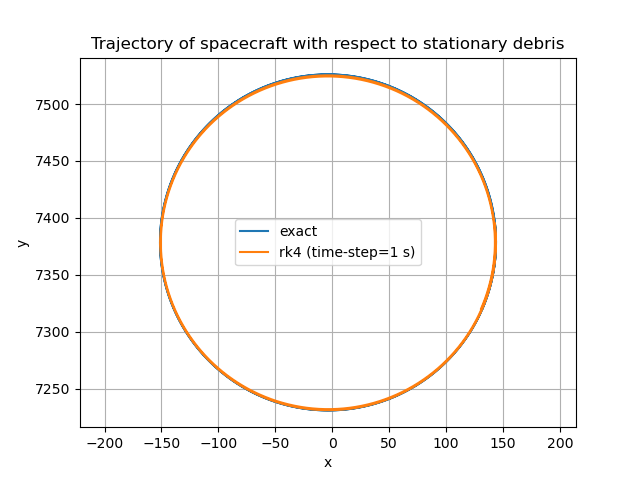

In [739]:
x1 = x_relative_position
y1 = y_relative_position              

x2=  x_rk4
y2 = y_rk4             

# Create the plot
plt.figure()
plt.plot(x1, y1, label='exact')
plt.plot(x2, y2, label='rk4 (time-step=1 s)')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of spacecraft with respect to stationary debris')
plt.legend()
plt.grid(True)

plt.axis('equal')
# Show the plot
plt.show()


In [740]:
error_rk4_x_max=np.abs(x_rk4-x_relative_position).max()
error_rk4_x_max

0.9492847052059119

In [741]:
error_rk4_y_max=np.abs(y_rk4-y_relative_position).max()
error_rk4_y_max

1.7939814351311725

In [742]:
# So the RK4 algorithm with the time step of 1 second gives accoracy upto couple of meters for 13000 seconds
# For better accuracy, let's take the time-step to 0.05 seconds

h=0.05
t_final=75000


In [743]:
# Orbit_propogation of target with smaller step size

# specific angular momentum

h_t=np.sqrt(mu*a_t*(1-e_t**2))

# Initial mean anamoly calculation
    
E0=2 * np.arctan(np.sqrt((1 - e_t) / (1 + e_t)) * np.tan(f0_t / 2))
M0=E0-e_t*np.sin(E0)

# Mean motion calculation 

n_t = np.sqrt(mu / a_t**3)

# Kepler's equation

def kepler_solve(M, e, tol=1e-6):
    E = M 
    for _ in range(100):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E

# inertial position and inertial velocity of target as function of time


f_dot_target=[]
DCM_in_to_hill_target=[]
r_inertial_target=[]
v_inertial_target=[]
f_target=[]
time_propogation=[]


for t in np.arange(6300,t_final,h): 
    
    M = M0 + n_t * t
    E=kepler_solve(M, e_t)
    
    f_t = 2 * np.arctan(np.sqrt((1 + e_t) / (1 - e_t)) * np.tan(E / 2))
    f_target.append(f_t)
    
    r_t=(a_t * (1 - e_t**2)) / (1 + e_t * np.cos(f_t))
    v_r_t=(mu/h_t)*e_t*np.sin(f_t)
    v_t_t=(mu/h_t)*(1+e_t*np.cos(f_t))
    f_dot_t=h_t/r_t**2
    f_dot_target.append(f_dot_t)
    
    theta1=Omega_t
    theta2=i_t
    theta3=omega_t+f_t
  
    c1, s1 = np.cos(theta1), np.sin(theta1)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    c3, s3 = np.cos(theta3), np.sin(theta3)
    
    DCM_hill_to_inertial= np.array([
        [ c1 * c3 - s1 * c2 * s3,  -c1 * s3 - s1 * c2 * c3,  s1 * s2],
        [ s1 * c3 + c1 * c2 * s3,  -s1 * s3 + c1 * c2 * c3, -c1 * s2],
        [ s2 * s3,                  s2 * c3,                c2]])
    
    DCM_inertial_to_hill=np.linalg.inv(DCM_hill_to_inertial)
    DCM_in_to_hill_target.append(DCM_inertial_to_hill)
    
    r_in_t=DCM_hill_to_inertial @ np.array([[r_t],[0],[0]])
    r_inertial_target.append(r_in_t)
    
    v_in_t=DCM_hill_to_inertial @ np.array([[v_r_t],[v_t_t],[0]])
    v_inertial_target.append(v_in_t)
    
    time_propogation.append(t)
    
    
    
r_inertial_target=np.array(r_inertial_target)
v_inertial_target=np.array(v_inertial_target)
f_target=np.array(f_target)
f_dot_target=np.array(f_dot_target)
time_propogation=np.array(time_propogation)
DCM_in_to_hill_target=np.array(DCM_in_to_hill_target)

In [744]:
Rc_vec= np.linalg.norm(r_inertial_target, axis=1).flatten()
a=DCM_in_to_hill_target

In [745]:
# Orbit_propogation of satellite with smaller step size
# Satellite is 1 second ahead in same orbit as target

# specific angular momentum

h_t=np.sqrt(mu*a_t*(1-e_t**2))

# Initial mean anamoly calculation
    
E0=2 * np.arctan(np.sqrt((1 - e_t) / (1 + e_t)) * np.tan(f0_t / 2))
M0=E0-e_t*np.sin(E0)

# Mean motion calculation 

n_t = np.sqrt(mu / a_t**3)

# Kepler's equation

def kepler_solve(M, e, tol=1e-6):
    E = M 
    for _ in range(100):
        delta = (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
        E -= delta
        if abs(delta) < tol:
            break
    return E

# inertial position and inertial velocity of target as function of time


f_dot_target=[]
DCM_in_to_hill_target=[]
r_inertial_target=[]
v_inertial_target=[]
f_target=[]
time_propogation=[]




for t in np.arange(6301,t_final,h): 
    
    M = M0 + n_t * t
    E=kepler_solve(M, e_t)
    
    f_t = 2 * np.arctan(np.sqrt((1 + e_t) / (1 - e_t)) * np.tan(E / 2))
    f_target.append(f_t)
    
    r_t=(a_t * (1 - e_t**2)) / (1 + e_t * np.cos(f_t))
    v_r_t=(mu/h_t)*e_t*np.sin(f_t)
    v_t_t=(mu/h_t)*(1+e_t*np.cos(f_t))
    f_dot_t=h_t/r_t**2
    f_dot_target.append(f_dot_t)
    
    theta1=Omega_t
    theta2=i_t
    theta3=omega_t+f_t
  
    c1, s1 = np.cos(theta1), np.sin(theta1)
    c2, s2 = np.cos(theta2), np.sin(theta2)
    c3, s3 = np.cos(theta3), np.sin(theta3)
    
    DCM_hill_to_inertial= np.array([
        [ c1 * c3 - s1 * c2 * s3,  -c1 * s3 - s1 * c2 * c3,  s1 * s2],
        [ s1 * c3 + c1 * c2 * s3,  -s1 * s3 + c1 * c2 * c3, -c1 * s2],
        [ s2 * s3,                  s2 * c3,                c2]])
    
    DCM_inertial_to_hill=np.linalg.inv(DCM_hill_to_inertial)
    DCM_in_to_hill_target.append(DCM_inertial_to_hill)
    
    r_in_t=DCM_hill_to_inertial @ np.array([[r_t],[0],[0]])
    r_inertial_target.append(r_in_t)
    
    v_in_t=DCM_hill_to_inertial @ np.array([[v_r_t],[v_t_t],[0]])
    v_inertial_target.append(v_in_t)
    
    time_propogation.append(t)
    
    
    
r_inertial_target=np.array(r_inertial_target)
v_inertial_target=np.array(v_inertial_target)
f_target=np.array(f_target)
f_dot_target=np.array(f_dot_target)
time_propogation=np.array(time_propogation)
DCM_in_to_hill_target=np.array(DCM_in_to_hill_target)

In [746]:
Rd_vec= np.linalg.norm(r_inertial_target, axis=1).flatten()
b=DCM_in_to_hill_target

In [747]:
points=int((t_final-6300)/h-100)
rel_pos=[]
for i in range(points+1):
    rel_pos.append(a[i] @ np.transpose(b[i]) @ np.array([[Rd_vec[i]],[0],[0]])-np.array([[Rc_vec[i]],[0],[0]]))

In [748]:
x_exact = np.array(rel_pos)[:, 0, 0]  
y_exact = np.array(rel_pos)[:, 1, 0]  
z_exact = np.array(rel_pos)[:, 2, 0] 

In [749]:
x_exact[0]

142.9084213944152

In [750]:
y_exact[0]

7395.009210914537

In [751]:
z_exact[0]

-2.0276437168586753e-10

In [752]:
(x_exact[1]-x_exact[0])/h

0.01686355099081993

In [753]:
(y_exact[1]-y_exact[0])/h

-0.14844558278127806

In [754]:
(z_exact[1]-z_exact[0])/h

4.05528743371735e-09

In [755]:
# RK4 with smaller step size

def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p):
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)
    
    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x_exact[0]
y=y_exact[0]
z=0
x_dot=(x_exact[1]-x_exact[0])/h
y_dot=(y_exact[1]-y_exact[0])/h
z_dot=0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

time_propogation=[]
time_propogation.append(6300)

# semi latus rectum
p=a_t*(1-e_t**2)

for i in range(points):
    
    Rc=Rc_vec[i]
    Rc_dot=(Rc_vec[i+1]-Rc_vec[i])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
   
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    #time_propogation.append(t)

x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
#time_propogation=np.array(time_propogation)
    
    

In [756]:
error_rk4_x_max=np.abs(x_exact-x_rk4).max()
error_rk4_x_max

0.2587890487709785

In [757]:
error_rk4_y_max=np.abs(y_exact-y_rk4).max()
error_rk4_y_max

0.5679509353258254

In [758]:
# So, the RK4 with step size of 0.05 gives accuracy upto 15 centimeters (approx) for interval of 20000 s (approx) 
# Thus, if RK4 is run for approx 45000 to 50000 seconds, accuracy would be upto 35-40 centimeters, roughly spaeaking. 
# let's use this one

<IPython.core.display.Javascript object>


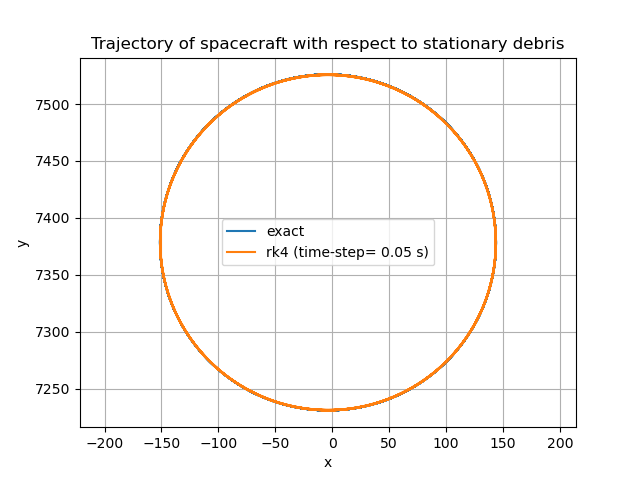

In [759]:
# plotting exact relative motion of satellite and comparing with RK4

x1 = x_exact
y1 = y_exact         

x2=  x_rk4
y2 = y_rk4             

# Create the plot
plt.figure()
plt.plot(x1, y1, label='exact')
plt.plot(x2, y2, label='rk4 (time-step= 0.05 s)')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of spacecraft with respect to stationary debris')
plt.legend()
plt.grid(True)

plt.axis('equal')
# Show the plot
plt.show()


In [760]:
# Let's bring the satellite closer to debris
# Let the time of manuver be 6395 seconds

# At the start of manuver, satellite is approximately 7395 meters away from debris in y ( along-track ) direction
# At the end of manuver, satellite is 1000 meters away from debris in y ( along-track ) direction
# Thus, the speed in y-direction is -1 m/s 

# At the start of manuver, satellite is approximately 143 meters away from debris in x ( radial ) direction
# At the end of manuver, satellite is 300 meters away from debris in y ( radial ) direction
# Thus, the speed in x-direction is 0.02455 m/s  


In [761]:
def y_desired(i):
    y_desired = y_exact[0] - i*h*1
    y_dot_desired = -1
    return y_desired , y_dot_desired

def x_desired(i):
    x_desired = x_exact[0] + i*h*0.02455
    x_dot_desired = 0.02455
    return x_desired , x_dot_desired    

In [762]:
# Bringing satellite closer to debris
# Manuver starts at 6300 seconds

def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
    
    K1=0.01
    P1=0.5
    
    K2=0.0001
    P2=0.015
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)-K1*(x-x_desired(i)[0])-P1*(x_dot-x_desired(i)[1])
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)-K2*(y-y_desired(i)[0])-P2*(y_dot-y_desired(i)[1])
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x_exact[0]
y=y_exact[0]
z=0
x_dot=(x_exact[1]-x_exact[0])/h
y_dot=(y_exact[1]-y_exact[0])/h
z_dot=0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300)

t_final=6300+6395
points=int((t_final-6300)/h)

# semi latus rectum
p=a_t*(1-e_t**2)

# for fuel cost

a_mag = []

for i in range(points):
    
    Rc=Rc_vec[i]
    Rc_dot=(Rc_vec[i+1]-Rc_vec[i])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
    time.append(6300+(i+1)*h)
    
    # for fuel cost
    
    a1 = (1/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    a2 = (1/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    a3 = (1/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    a_mag.append(np.sqrt(a1**2+a2**2+a3**2))
    
   
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)

a_mag=np.array(a_mag)
time=np.array(time)

<IPython.core.display.Javascript object>


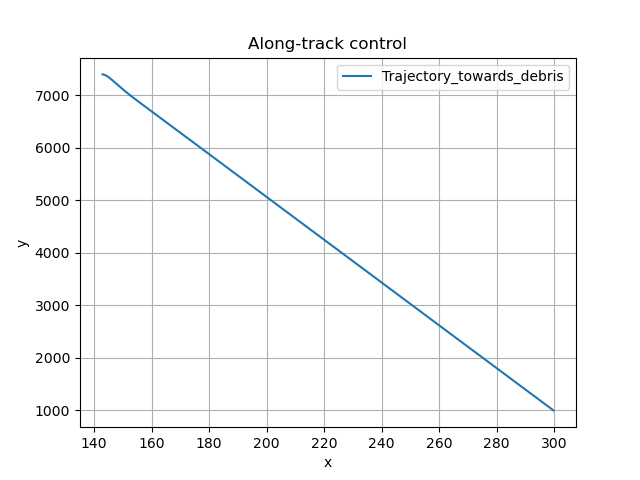

In [763]:
plt.figure()
plt.plot(x_rk4, y_rk4, label='Trajectory_towards_debris')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Along-track control')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


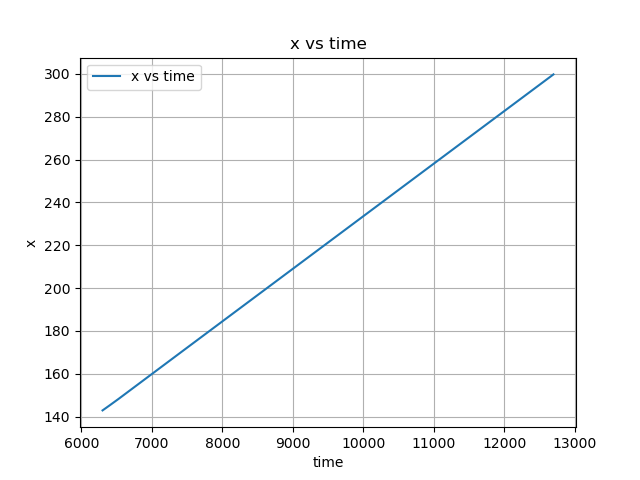

In [764]:
plt.figure()
plt.plot(time, x_rk4, label='x vs time')

plt.xlabel('time')
plt.ylabel('x')
plt.title('x vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


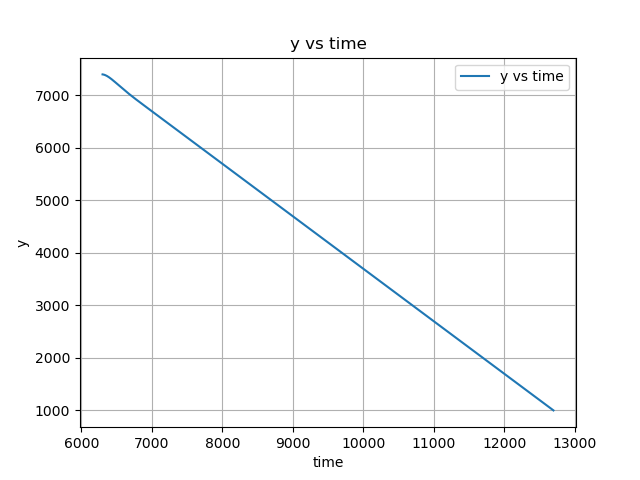

In [765]:
plt.figure()
plt.plot(time, y_rk4, label='y vs time')

plt.xlabel('time')
plt.ylabel('y')
plt.title('y vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


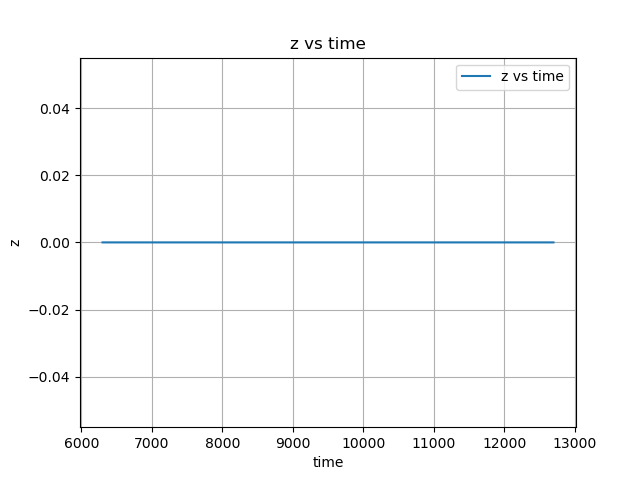

In [766]:
plt.figure()
plt.plot(time, z_rk4, label='z vs time')

plt.xlabel('time')
plt.ylabel('z')
plt.title('z vs time')
plt.legend()
plt.grid(True)


<IPython.core.display.Javascript object>


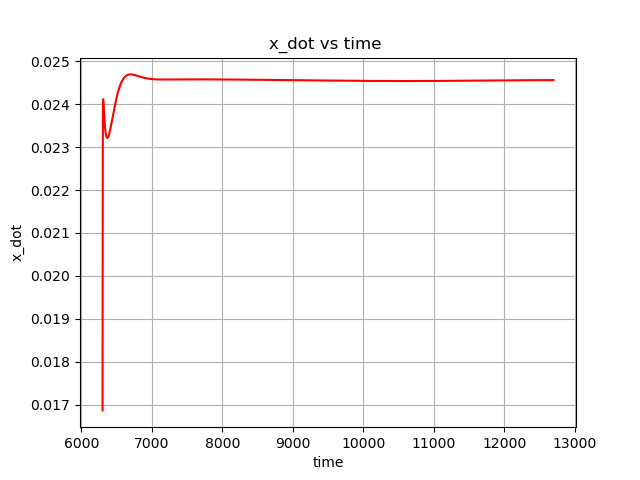

<IPython.core.display.Javascript object>


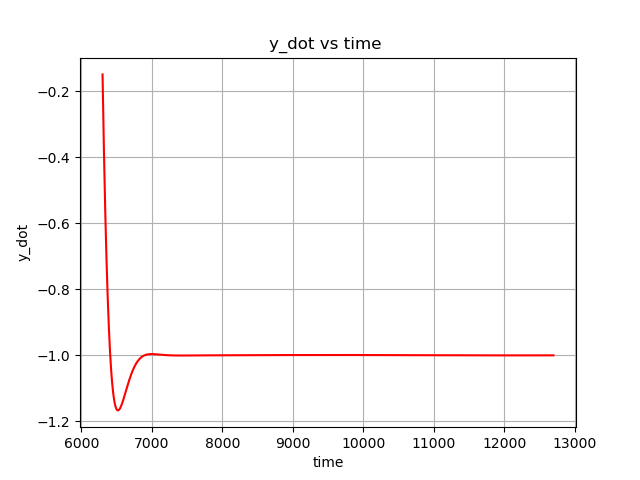

<IPython.core.display.Javascript object>


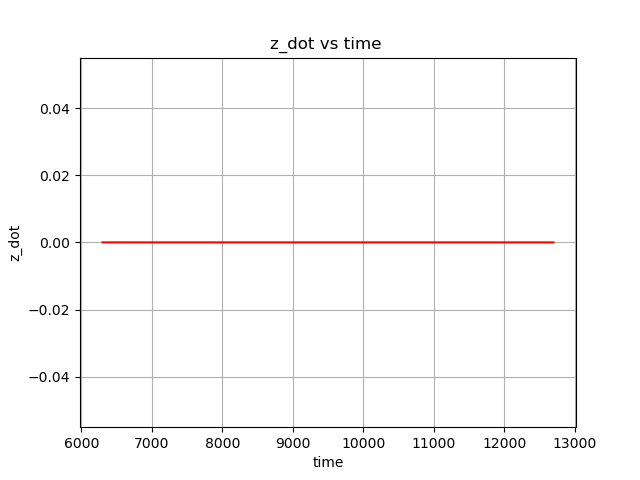

In [767]:
plt.figure()
plt.plot(time, x_dot_rk4, 'red')
plt.xlabel('time')
plt.ylabel('x_dot')
plt.title('x_dot vs time ')
plt.grid(True)

plt.figure()
plt.plot(time, y_dot_rk4, 'red')
plt.xlabel('time')
plt.ylabel('y_dot')
plt.title('y_dot vs time ')
plt.grid(True)

plt.figure()
plt.plot(time, z_dot_rk4, 'red')
plt.xlabel('time')
plt.ylabel('z_dot')
plt.title('z_dot vs time ')
plt.grid(True)

In [768]:
x_rk4[-1]

299.7901697503888

In [769]:
y_rk4[-1]

999.6841010704559

In [770]:
z_rk4[-1]

0.0

In [771]:
x_dot_rk4[-1]

0.02456374759731915

In [772]:
y_dot_rk4[-1]

-1.0002253650247677

In [773]:
z_dot_rk4[-1]

0.0

In [774]:
time[-1]

12695.0

In [775]:
# Fuel cost calculation
# The spacecraft mass before the manuver is 193.61721673063607 kg 

# Inputs

a_mag = a_mag          # np.array of acceleration magnitudes [m/s²], one per time step
dt = h                 # time step [s]
Isp = 300              # specific impulse [s]
g0 = 9.80665           # standard gravity [m/s²]
m0 = 193.61721673063607               # initial mass [kg]

# Initialize
mass = [m0]

# Loop through time
F=[]
for a in a_mag:
    m = mass[-1]
    thrust = m * a                             # F = m*a
    mdot = thrust / (Isp * g0)                 # ṁ = F / (Isp * g₀)
    m_new = m - mdot * dt                      # new mass after burning
    mass.append(m_new)
    F.append(thrust)

# Final results

m_final = mass[-1]
delta_m = m0 - m_final

print('initial mass of spacecraft is ',m0 ,'kg')
print('final mass of spacecraft is ',m_final ,'kg')
print('fuel consumed is', delta_m, 'kg')


initial mass of spacecraft is  193.61721673063607 kg
final mass of spacecraft is  193.53844040580088 kg
fuel consumed is 0.07877632483518937 kg


In [776]:
F.append(5.85e-5)   # placeholder 
F[-1]
np.array(F).shape

(127901,)

In [777]:
time.shape

(127901,)

<IPython.core.display.Javascript object>


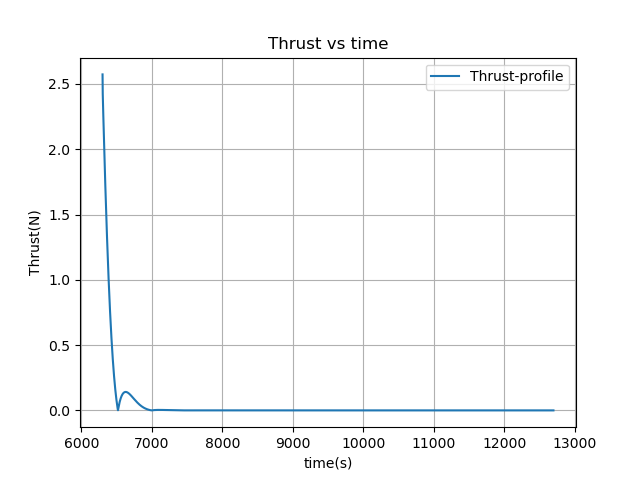

In [778]:
F=np.array(F)

plt.figure()
plt.plot(time, F, label='Thrust-profile')

plt.xlabel('time(s)')
plt.ylabel('Thrust(N)')
plt.title('Thrust vs time')
plt.legend()
plt.grid(True)

In [779]:
time_propogation=time
time_propogation.shape

(127901,)

In [780]:
velocity_mag = np.sqrt(x_dot_rk4**2+y_dot_rk4**2+z_dot_rk4**2)
velocity_mag

array([0.14940037, 0.15005584, 0.15071065, ..., 1.00052697, 1.00052696,
       1.00052694])

In [781]:
velocity_mag.shape

(127901,)

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# --- Downsample data ---
time = time_propogation[::20]
X1 = x_rk4[::20]
Y1 = y_rk4[::20]
Z1 = z_rk4[::20]
thrust = F[::20]
velocity = velocity_mag[::20]

# Ensure arrays are aligned
min_len = min(len(time), len(thrust), len(velocity), len(X1))
time = time[:min_len]
thrust = thrust[:min_len]
velocity = velocity[:min_len]
X1 = X1[:min_len]
Y1 = Y1[:min_len]
Z1 = Z1[:min_len]

# --- Set up figure ---
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Width and updated height for velocity/thrust plots
plot_width = 0.22
plot_height = 0.275  # Increased by 25%
plot_left = 0.08

# --- Velocity Plot (top) ---
ax_velocity = fig.add_axes([plot_left, 0.60, plot_width, plot_height])
ax_velocity.set_xlim(time[0]-500, time[-1]+500)
ax_velocity.set_ylim(np.min(velocity), np.max(velocity)+0.05)
ax_velocity.set_xlabel("Time (s)")
ax_velocity.set_ylabel("Velocity (m/s)")
ax_velocity.set_title("Velocity vs Time")
ax_velocity.grid(True)
velocity_line, = ax_velocity.plot([], [], 'r-', linewidth=2.0)

# --- Thrust Plot (bottom) ---
ax_thrust = fig.add_axes([plot_left, 0.19, plot_width, plot_height])
ax_thrust.set_xlim(time[0]-500, time[-1]+500)
ax_thrust.set_ylim(np.min(thrust), np.max(thrust)+0.25)
ax_thrust.set_xlabel("Time (s)")
ax_thrust.set_ylabel("Thrust (N)")
ax_thrust.set_title("Thrust vs Time")
ax_thrust.grid(True)
thrust_line, = ax_thrust.plot([], [], 'r-', linewidth=2.0)

# --- 3D Plot (unchanged in size/position) ---
ax = fig.add_axes([0.32, 0.1, 0.6, 0.8], projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title("Approaching Closer to Debris", pad=1)  # Moved title downward

# Enlarged markers
ax.plot([0], [0], [0], 'go', markersize=10, label='Debris')
point1, = ax.plot([], [], [], 'ro', markersize=9, label='Spacecraft')
trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)

# Axis limits
ax.set_xlim(-300, 300)
ax.set_ylim(-1000, 8000)
ax.set_zlim(-0.5, 0.5)

# Moved legend to far right (but not off screen)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

# Global time title moved upward
title = fig.suptitle('', y=0.95)

# --- Update function ---
current_frame = [0]
is_animating = [True]

def update_frame(frame):
    point1.set_data(X1[frame], Y1[frame])
    point1.set_3d_properties(Z1[frame])
    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])

    thrust_line.set_data(time[:frame+1], thrust[:frame+1])
    velocity_line.set_data(time[:frame+1], velocity[:frame+1])

    title.set_text(f'Time = {time[frame]:.2f} sec')
    fig.canvas.draw_idle()

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)
    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- UI Controls ---
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time) - 1,
    step=1,
    description='Frame:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

toggle_button = widgets.ToggleButton(
    value=True,
    description='⏸ Pause',
    tooltip='Toggle animation',
    icon='pause'
)

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')

display(widgets.HBox([toggle_button, slider]))

# --- Save as Video ---
from matplotlib.animation import FFMpegWriter
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=450, metadata=dict(artist='Me'), bitrate=12000)
ani.save("spacecraft_animation_with_velocity_and_thrust.mp4", writer=writer)

print("Saved video as 'spacecraft_animation_with_velocity_and_thrust.mp4'")


In [782]:
# Thus final x distance is about 300 meters 
# final y distance is about 1000 meters 

# Let's insert satellite in circular spiral trajectory at 12695 seconds 
# At 12695 seconds, the position and velocity are

t0 = 12695
x0 = 299.79016975132043
y0 = 999.684101070862
z0 = 0
x_dot_0 = 0.024563747597319285
y_dot_0 = -1.0002253650247672
z_dot_0 = 0

# Let the manuver end at 12695 + 9000 seconds

t_final = 12695 + 9000

# The circular spiral trajectory is as follows

R = x0                  # radius    
T = 1800                # period in seconds
alpha = (2*np.pi)/T

def x_desired_spiral(i):
    
    R = 299.79016975132043
    T = 1800
    alpha = (2*np.pi)/T
    
    t = i*h
    x_desired_spiral = R * np.cos(alpha*t)
    x_dot_desired_spiral = -R * alpha * np.sin(alpha*t)
    
    return x_desired_spiral, x_dot_desired_spiral

def z_desired_spiral(i):
    
    R = 299.79016975132043
    T = 1800
    alpha = (2*np.pi)/T
    
    t = i*h
    z_desired_spiral = R * np.sin(alpha*t)
    z_dot_desired_spiral = R * alpha * np.cos(alpha*t)
    
    return z_desired_spiral, z_dot_desired_spiral

def y_desired_spiral(i):
    
    t=i*h
    y_desired_spiral = 999.684101070862 - 0.22222222222*t
    y_dot_desired_spiral = -0.22222222222
    
    return y_desired_spiral, y_dot_desired_spiral
    
    



In [783]:
# Spiral trajectory for choreography


def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
    
    K1=0.00001
    P1=1
    
    K2=0.005
    P2=0.8
    
    K3=0.00001
    P3=0.04
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)-K1*(x-x_desired_spiral(i)[0])-P1*(x_dot-x_desired_spiral(i)[1])
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)-K2*(y-y_desired_spiral(i)[0])-P2*(y_dot-y_desired_spiral(i)[1])
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)-K3*(z-z_desired_spiral(i)[0])-P3*(z_dot-z_desired_spiral(i)[1])

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x0
y=y0
z=z0
x_dot=x_dot_0
y_dot=y_dot_0
z_dot=z_dot_0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300+6395)

t_final=6300+6395+9000
points=int((t_final-6300-6395)/h)

# semi latus rectum
p=a_t*(1-e_t**2)

# for fuel cost

a_mag = []

for i in range(points):
    
    Rc=Rc_vec[i+127900]
    Rc_dot=(Rc_vec[i+1+127900]-Rc_vec[i+127900])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
    time.append(6300+6395+(i+1)*h)
    
    # for fuel cost
    
    a1 = (1/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    a2 = (1/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    a3 = (1/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    a_mag.append(np.sqrt(a1**2+a2**2+a3**2))
    
   
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)

a_mag=np.array(a_mag)
time=np.array(time)

<IPython.core.display.Javascript object>


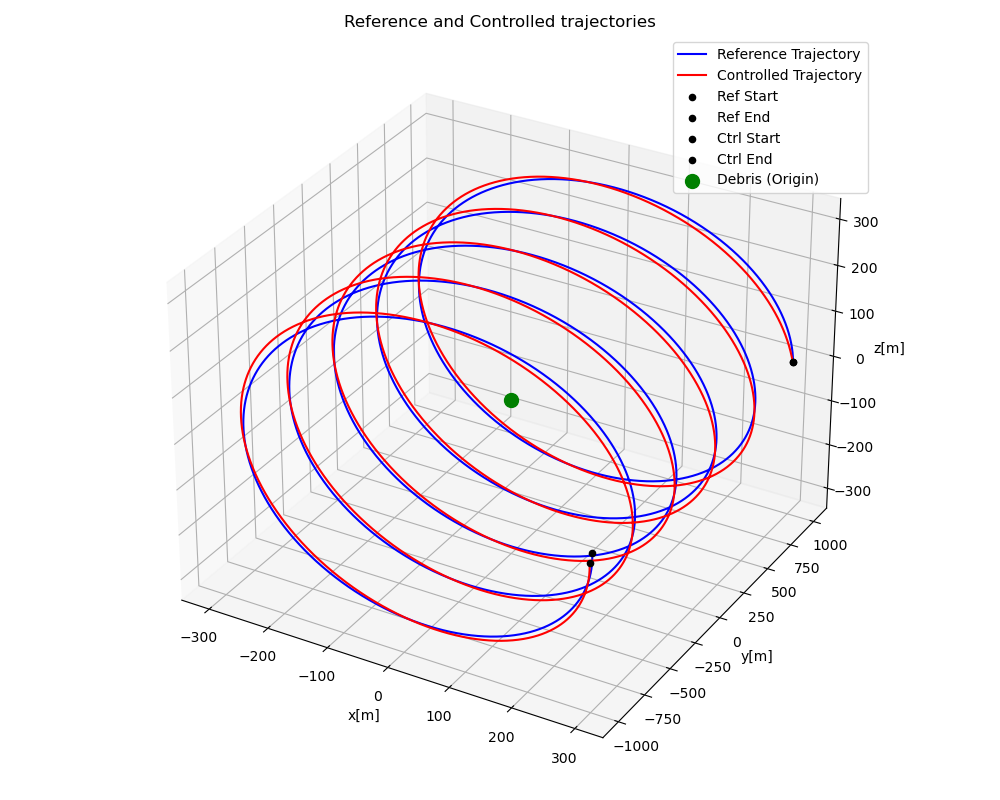

In [784]:
# plotting reference and controlled trajectory

x_ref=[]
y_ref=[]
z_ref=[]

x_dot_ref=[]
y_dot_ref=[]
z_dot_ref=[]


for i in range(points+1):
    
    x_ref.append(x_desired_spiral(i)[0])
    y_ref.append(y_desired_spiral(i)[0])
    z_ref.append(z_desired_spiral(i)[0])
    
    x_dot_ref.append(x_desired_spiral(i)[1])
    y_dot_ref.append(y_desired_spiral(i)[1])
    z_dot_ref.append(z_desired_spiral(i)[1])

x_ref, y_ref, z_ref = np.array(x_ref), np.array(y_ref), np.array(z_ref)
x_ctrl, y_ctrl, z_ctrl = x_rk4, y_rk4, z_rk4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot reference spiral trajectory
ax.plot(x_ref, y_ref, z_ref, label='Reference Trajectory', color='blue')
ax.scatter(x_ref[0], y_ref[0], z_ref[0], color='black', marker='o', label='Ref Start')
ax.scatter(x_ref[-1], y_ref[-1], z_ref[-1], color='black', marker='o', label='Ref End')

# Plot controlled spiral trajectory
ax.plot(x_ctrl, y_ctrl, z_ctrl, label='Controlled Trajectory', color='red')
ax.scatter(x_ctrl[0], y_ctrl[0], z_ctrl[0], color='black', marker='o', label='Ctrl Start')
ax.scatter(x_ctrl[-1], y_ctrl[-1], z_ctrl[-1], color='black', marker='o', label='Ctrl End')

# Plot debris at origin
ax.scatter(0, 0, 0, color='green', marker='o', s=100, label='Debris (Origin)')

# Labels and legend
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')
ax.set_zlabel('z[m]')
ax.set_title('Reference and Controlled trajectories')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


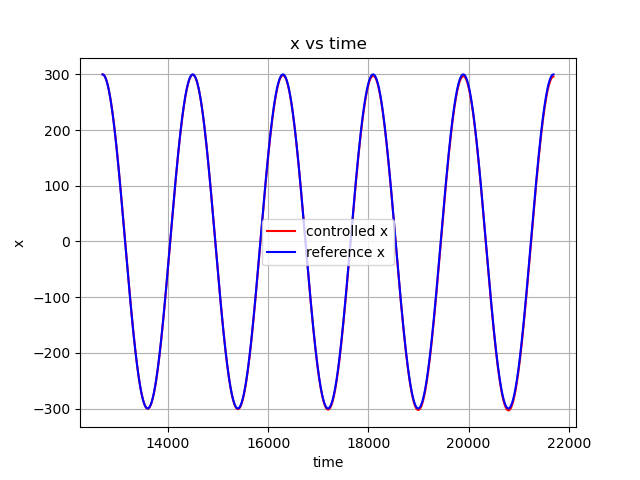

In [785]:
# x

plt.figure()
plt.plot(time, x_ctrl, 'red', label='controlled x')
plt.plot(time, x_ref, 'blue', label='reference x')

plt.xlabel('time')
plt.ylabel('x')
plt.title('x vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


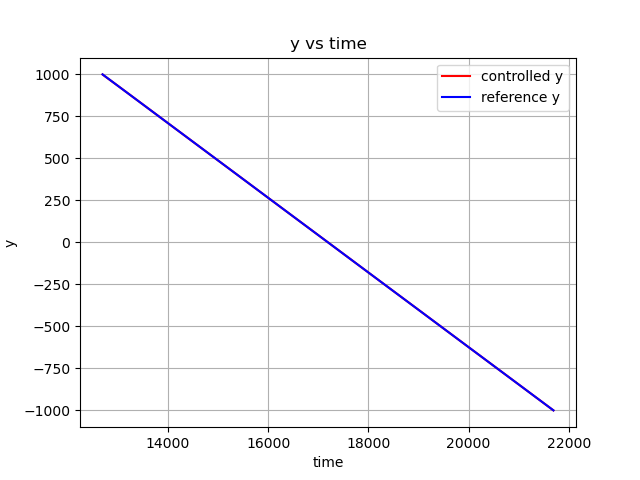

In [786]:
# y

plt.figure()
plt.plot(time, y_ctrl, 'red', label='controlled y')
plt.plot(time, y_ref, 'blue', label='reference y')

plt.xlabel('time')
plt.ylabel('y')
plt.title('y vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


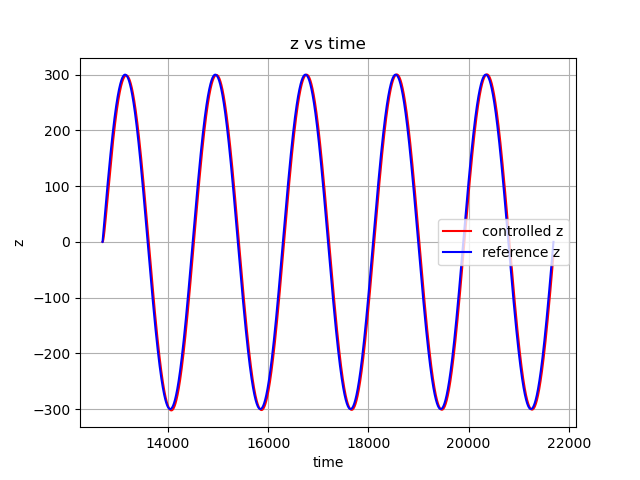

In [787]:
# z

plt.figure()
plt.plot(time, z_ctrl, 'red', label='controlled z')
plt.plot(time, z_ref, 'blue', label='reference z')

plt.xlabel('time')
plt.ylabel('z')
plt.title('z vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


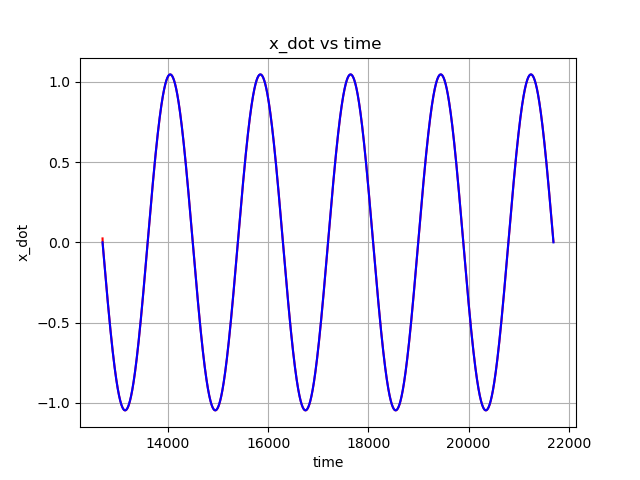

<IPython.core.display.Javascript object>


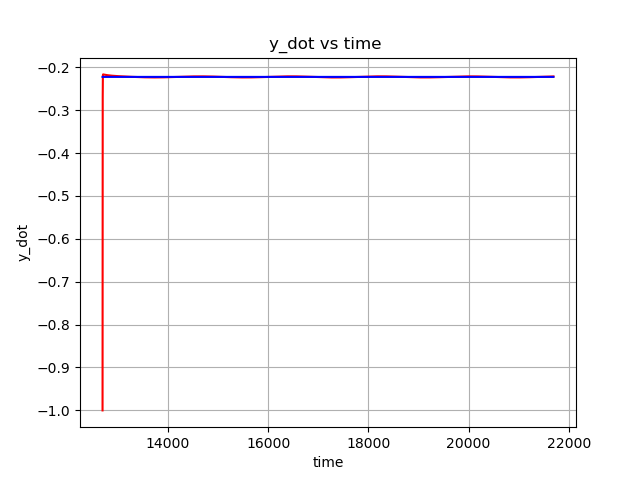

<IPython.core.display.Javascript object>


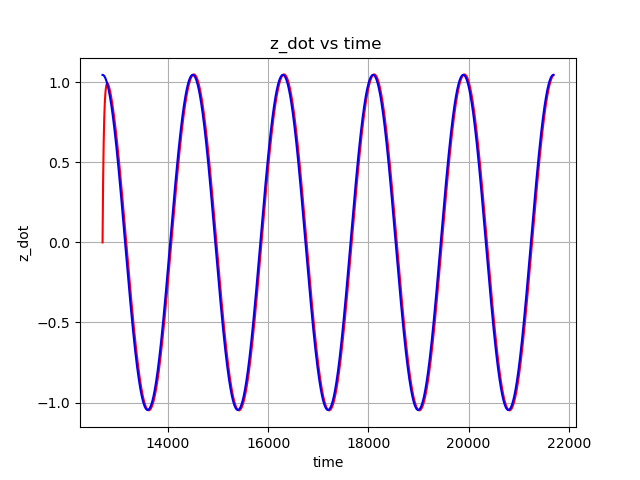

In [788]:
plt.figure()
plt.plot(time, x_dot_rk4, 'red')
plt.plot(time, x_dot_ref, 'blue')
plt.xlabel('time')
plt.ylabel('x_dot')
plt.title('x_dot vs time ')
plt.grid(True)

plt.figure()
plt.plot(time, y_dot_rk4, 'red')
plt.plot(time, y_dot_ref, 'blue')
plt.xlabel('time')
plt.ylabel('y_dot')
plt.title('y_dot vs time ')
plt.grid(True)

plt.figure()
plt.plot(time, z_dot_rk4, 'red')
plt.plot(time, z_dot_ref, 'blue')
plt.xlabel('time')
plt.ylabel('z_dot')
plt.title('z_dot vs time ')
plt.grid(True)

In [789]:
x_rk4[-1]

295.9473040065696

In [790]:
y_rk4[-1]

-1000.4872904068574

In [791]:
z_rk4[-1]

-24.256409644054315

In [792]:
x_dot_rk4[-1]

0.004186813013698747

In [793]:
y_dot_rk4[-1]

-0.2211335194832819

In [794]:
z_dot_rk4[-1]

1.0457946290756857

In [795]:
time[-1]

21695.0

In [796]:
np.sqrt(x_ctrl**2 + y_ctrl**2 +  z_ctrl**2).max()

1043.6677861337787

In [797]:
np.sqrt(x_ctrl**2 + y_ctrl**2 +  z_ctrl**2).min()

294.30156365886836

In [798]:
# Thus the closest reach is around 294 meters so far

In [799]:
# Fuel cost calculation

# Inputs

a_mag = a_mag          # np.array of acceleration magnitudes [m/s²], one per time step
dt = h                 # time step [s]
Isp = 300              # specific impulse [s]
g0 = 9.80665           # standard gravity [m/s²]
m0 = 193.53844040580088               # initial mass [kg]

# Initialize
mass = [m0]

# Loop through time
F=[]
for a in a_mag:
    m = mass[-1]
    thrust = m * a                             # F = m*a
    mdot = thrust / (Isp * g0)                 # ṁ = F / (Isp * g₀)
    m_new = m - mdot * dt                      # new mass after burning
    mass.append(m_new)
    F.append(thrust)

# Final results

m_final = mass[-1]
delta_m = m0 - m_final

print('initial mass of spacecraft is ',m0 ,'kg')
print('final mass of spacecraft is ',m_final ,'kg')
print('fuel consumed is', delta_m, 'kg')


initial mass of spacecraft is  193.53844040580088 kg
final mass of spacecraft is  191.29486020685283 kg
fuel consumed is 2.2435801989480524 kg


In [800]:
F.append(0.701005)   # placeholder 
np.array(F).shape

(180001,)

In [801]:
time.shape

(180001,)

<IPython.core.display.Javascript object>


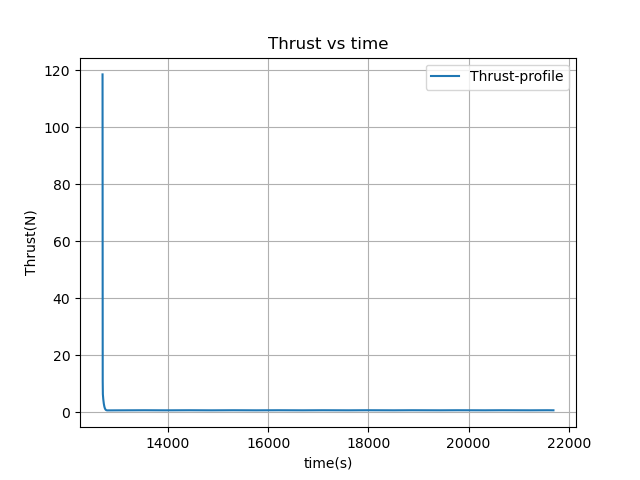

In [802]:
F=np.array(F)

plt.figure()
plt.plot(time, F, label='Thrust-profile')

plt.xlabel('time(s)')
plt.ylabel('Thrust(N)')
plt.title('Thrust vs time')
plt.legend()
plt.grid(True)

In [803]:
F[-1]

0.701005

In [804]:
F.max()

118.47425353750279

In [805]:
F.min()

0.6651013455233958

In [806]:
np.mean(F)

0.7334000119631278

In [807]:
velocity_mag = np.sqrt(x_dot_rk4**2+y_dot_rk4**2+z_dot_rk4**2)
velocity_mag

array([1.00052694, 0.96999754, 0.94066119, ..., 1.06889934, 1.06891295,
       1.06892655])

In [808]:
time_propogation = time

In [809]:
x_rk4.shape

(180001,)

In [810]:
time.shape

(180001,)

In [811]:
velocity_mag.shape

(180001,)

In [812]:
F.shape

(180001,)

In [813]:
time_propogation.shape

(180001,)

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# --- Downsample data ---
time = time_propogation[::20]
X1 = x_rk4[::20]
Y1 = y_rk4[::20]
Z1 = z_rk4[::20]
thrust = F[::20]
velocity = velocity_mag[::20]

# Ensure arrays are aligned
min_len = min(len(time), len(thrust), len(velocity), len(X1))
time = time[:min_len]
thrust = thrust[:min_len]
velocity = velocity[:min_len]
X1 = X1[:min_len]
Y1 = Y1[:min_len]
Z1 = Z1[:min_len]

# --- Set up figure ---
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Width and updated height for velocity/thrust plots
plot_width = 0.22
plot_height = 0.275  # Increased by 25%
plot_left = 0.08

# --- Velocity Plot (top) ---
ax_velocity = fig.add_axes([plot_left, 0.60, plot_width, plot_height])
ax_velocity.set_xlim(time[0]-500, time[-1]+500)
ax_velocity.set_ylim(np.min(velocity), np.max(velocity)+0.05)
ax_velocity.set_xlabel("Time (s)")
ax_velocity.set_ylabel("Velocity (m/s)")
ax_velocity.set_title("Velocity vs Time")
ax_velocity.grid(True)
velocity_line, = ax_velocity.plot([], [], 'r-', linewidth=2.0)

# --- Thrust Plot (bottom) ---
ax_thrust = fig.add_axes([plot_left, 0.19, plot_width, plot_height])
ax_thrust.set_xlim(time[0]-500, time[-1]+500)
ax_thrust.set_ylim(np.min(thrust), 130)
ax_thrust.set_xlabel("Time (s)")
ax_thrust.set_ylabel("Thrust (N)")
ax_thrust.set_title("Thrust vs Time")
ax_thrust.grid(True)
thrust_line, = ax_thrust.plot([], [], 'r-', linewidth=2.0)

# --- 3D Plot (unchanged in size/position) ---
ax = fig.add_axes([0.32, 0.1, 0.6, 0.8], projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title("Choreography of Debris", pad=1)  # Moved title downward

# Enlarged markers
ax.plot([0], [0], [0], 'go', markersize=10, label='Debris')
point1, = ax.plot([], [], [], 'ro', markersize=9, label='Spacecraft')
trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)

# Axis limits
ax.set_xlim(-300, 300)
ax.set_ylim(-1000, 1000)
ax.set_zlim(-300, 300)

# Moved legend to far right (but not off screen)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

# Global time title moved upward
title = fig.suptitle('', y=0.95)

# --- Update function ---
current_frame = [0]
is_animating = [True]

def update_frame(frame):
    point1.set_data(X1[frame], Y1[frame])
    point1.set_3d_properties(Z1[frame])
    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])

    thrust_line.set_data(time[:frame+1], thrust[:frame+1])
    velocity_line.set_data(time[:frame+1], velocity[:frame+1])

    title.set_text(f'Time = {time[frame]:.2f} sec')
    fig.canvas.draw_idle()

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)
    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- UI Controls ---
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time) - 1,
    step=1,
    description='Frame:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

toggle_button = widgets.ToggleButton(
    value=True,
    description='⏸ Pause',
    tooltip='Toggle animation',
    icon='pause'
)

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')

display(widgets.HBox([toggle_button, slider]))

# --- Save as Video ---
from matplotlib.animation import FFMpegWriter
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=450, metadata=dict(artist='Me'), bitrate=12000)
ani.save("spacecraft_animation_with_velocity_and_thrust.mp4", writer=writer)

print("Saved video as 'choreography.mp4'")


In [814]:
# Let's bring the spacecraft closer to debris now

# The mannuver starts at 6300+6395+9000 = 21695 seconds
# At the end of the manuver, the position of spacecraft relative to debris should be (0, -50, 0)
# At the end of manuver, the velocity of spacecraft relative to debris should be (0,0,0)
# After achieving these results, the spaceraft should hold at this position with minimal or zero control

# The values corresponding to time 21695 seconds are 

x0 = 295.9473040065696
y0 = -1000.4872904068574
z0 = -24.256409644054315
x_dot_0 = 0.004186813013698747
y_dot_0 = -0.2211335194832819
z_dot_0 = 1.0457946290756857

In [815]:
# approaching near debris


def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
  
    K1=0.000034
    P1=0.02
    
    K2=0.000013
    P2=0.01
    
    K3=0.00001
    P3=0.007
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)-K1*(x-0)-P1*(x_dot-0)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)-K2*(y-(-50))-P2*(y_dot-0)
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)-K3*(z-0)-P3*(z_dot-0)

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x0
y=y0
z=z0
x_dot=x_dot_0
y_dot=y_dot_0
z_dot=z_dot_0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300+6395+9000)

t_final=6300+6395+9000+7200
points=int((t_final-6300-6395-9000)/h)

# semi latus rectum
p=a_t*(1-e_t**2)

# for fuel cost

a_mag = []

for i in range(points):
    
    Rc=Rc_vec[i+307900]
    Rc_dot=(Rc_vec[i+1+307900]-Rc_vec[i+307900])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
    time.append(6300+6395+9000+(i+1)*h)
    
    # for fuel cost
    
    a1 = (1/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    a2 = (1/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    a3 = (1/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    a_mag.append(np.sqrt(a1**2+a2**2+a3**2))
    
   
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)

a_mag=np.array(a_mag)
time=np.array(time)

<IPython.core.display.Javascript object>


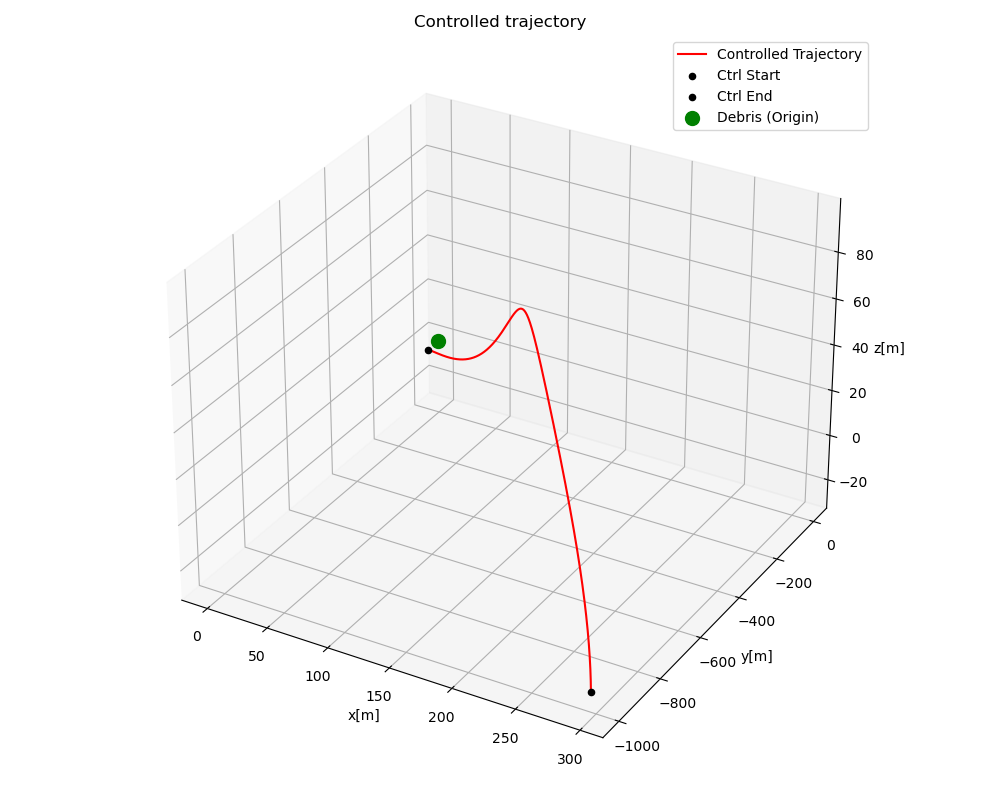

In [816]:
# plotting controlled trajectory

x_ctrl, y_ctrl, z_ctrl = x_rk4, y_rk4, z_rk4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_ctrl, y_ctrl, z_ctrl, label='Controlled Trajectory', color='red')
ax.scatter(x_ctrl[0], y_ctrl[0], z_ctrl[0], color='black', marker='o', label='Ctrl Start')
ax.scatter(x_ctrl[-1], y_ctrl[-1], z_ctrl[-1], color='black', marker='o', label='Ctrl End')

# Plot debris at origin
ax.scatter(0, 0, 0, color='green', marker='o', s=100, label='Debris (Origin)')

# Labels and legend
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')
ax.set_zlabel('z[m]')
ax.set_title('Controlled trajectory')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

C:\Users\jaysu\AppData\Local\Temp/ipykernel_8360/299897476.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


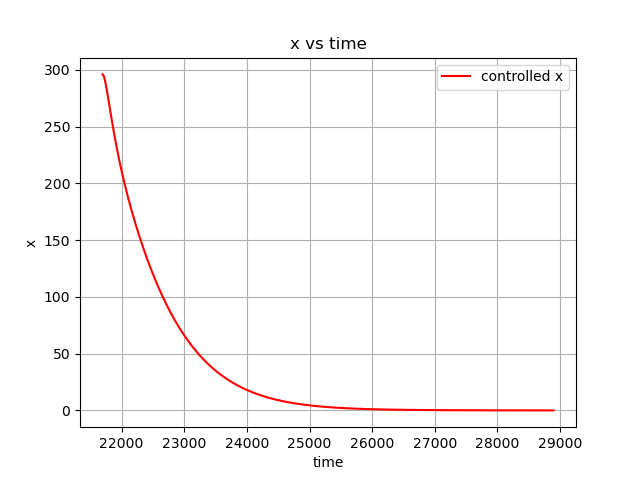

In [817]:
# x

plt.figure()
plt.plot(time, x_ctrl, 'red', label='controlled x')

plt.xlabel('time')
plt.ylabel('x')
plt.title('x vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


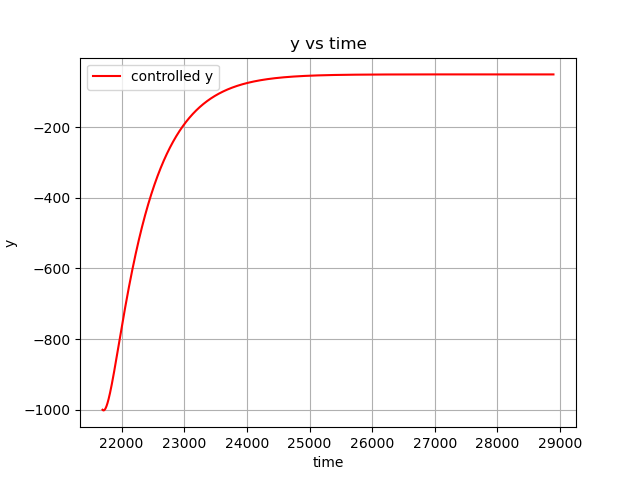

In [818]:
# y

plt.figure()
plt.plot(time, y_ctrl, 'red', label='controlled y')

plt.xlabel('time')
plt.ylabel('y')
plt.title('y vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


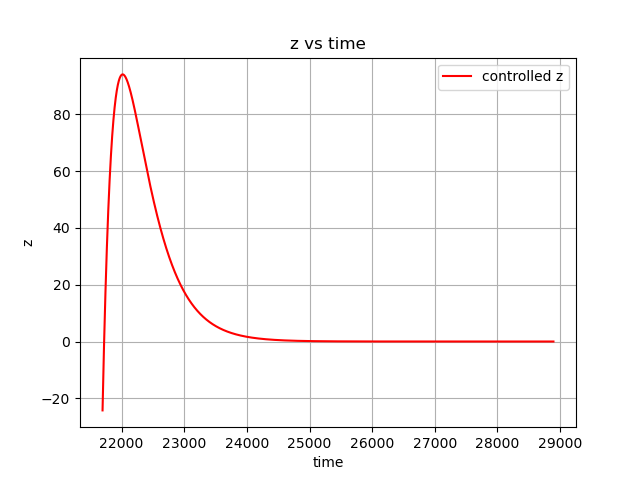

In [819]:
# z

plt.figure()
plt.plot(time, z_ctrl, 'red', label='controlled z')

plt.xlabel('time')
plt.ylabel('z')
plt.title('z vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


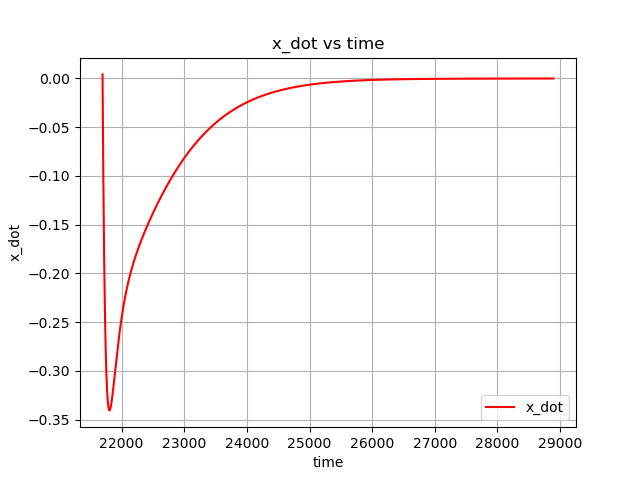

In [820]:
# x_dot

plt.figure()
plt.plot(time, x_dot_rk4, 'red', label='x_dot')


plt.xlabel('time')
plt.ylabel('x_dot')
plt.title('x_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


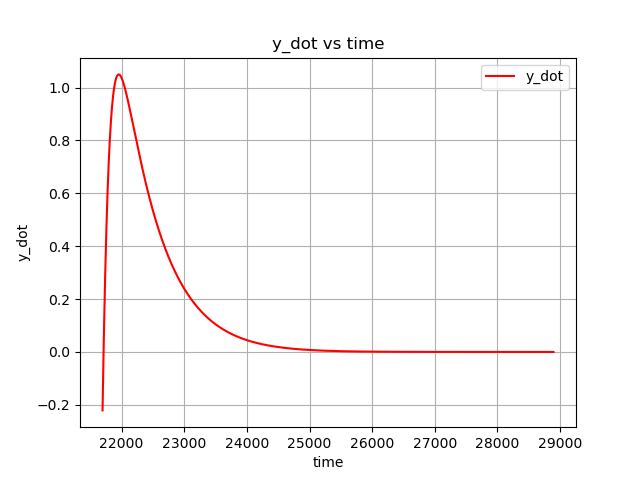

In [821]:
# y_dot

plt.figure()
plt.plot(time, y_dot_rk4, 'red', label='y_dot')


plt.xlabel('time')
plt.ylabel('y_dot')
plt.title('y_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


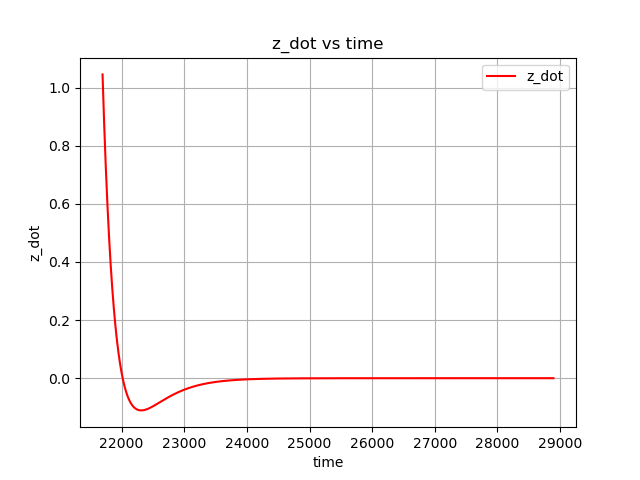

In [822]:
# z_dot

plt.figure()
plt.plot(time, z_dot_rk4, 'red', label='z_dot')


plt.xlabel('time')
plt.ylabel('z_dot')
plt.title('z_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


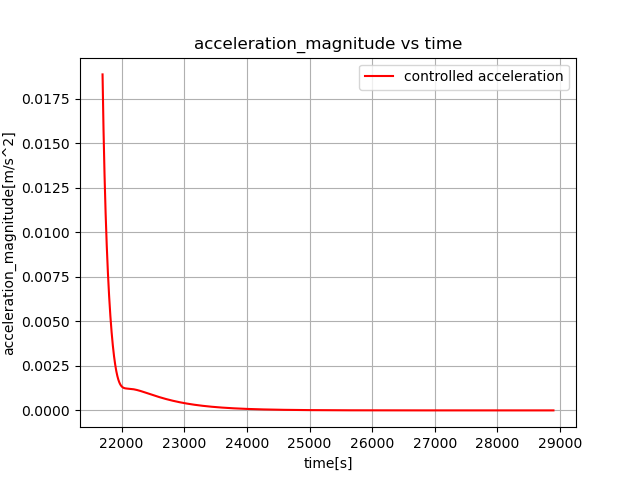

In [823]:
# a_mag

plt.figure()
plt.plot(time[:-1], a_mag, 'red', label='controlled acceleration')


plt.xlabel('time[s]')
plt.ylabel('acceleration_magnitude[m/s^2]')
plt.title('acceleration_magnitude vs time')
plt.legend()
plt.grid(True)

In [824]:
# Fuel cost calculation

# Inputs

a_mag = a_mag          # np.array of acceleration magnitudes [m/s²], one per time step
dt = h                 # time step [s]
Isp = 300              # specific impulse [s]
g0 = 9.80665           # standard gravity [m/s²]
m0 = 191.29486020685283               # initial mass [kg]

# Initialize
mass = [m0]

# Loop through time
F=[]
for a in a_mag:
    m = mass[-1]
    thrust = m * a                             # F = m*a
    mdot = thrust / (Isp * g0)                 # ṁ = F / (Isp * g₀)
    m_new = m - mdot * dt                      # new mass after burning
    mass.append(m_new)
    F.append(thrust)

# Final results

m_final = mass[-1]
delta_m = m0 - m_final

print('initial mass of spacecraft is ',m0 ,'kg')
print('final mass of spacecraft is ',m_final ,'kg')
print('fuel consumed is', delta_m, 'kg')


initial mass of spacecraft is  191.29486020685283 kg
final mass of spacecraft is  191.10635701272346 kg
fuel consumed is 0.18850319412936756 kg


In [825]:
F.append(1.599558e-05)   # placeholder 
np.array(F).shape

(144001,)

<IPython.core.display.Javascript object>


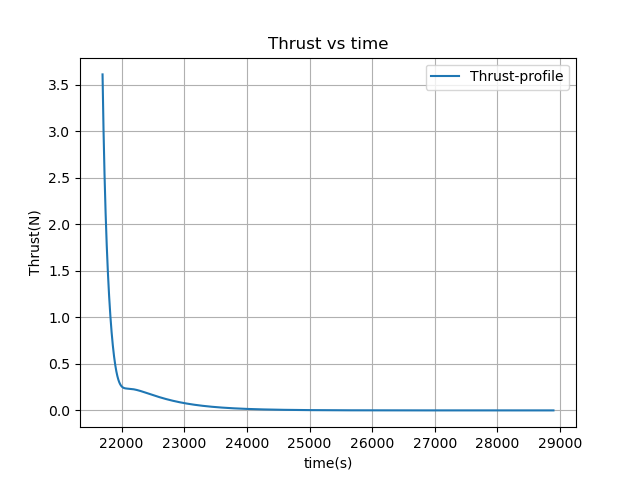

In [826]:
F=np.array(F)

plt.figure()
plt.plot(time, F, label='Thrust-profile')

plt.xlabel('time(s)')
plt.ylabel('Thrust(N)')
plt.title('Thrust vs time')
plt.legend()
plt.grid(True)

In [827]:
x_ctrl[-1]

-0.052572327381049784

In [828]:
y_ctrl[-1]

-49.978601748492025

In [829]:
z_ctrl[-1]

1.4247975642172033e-05

In [830]:
x_dot_rk4[-1]

-1.8973999030185932e-05

In [831]:
y_dot_rk4[-1]

-8.001602906405593e-05

In [832]:
z_dot_rk4[-1]

-3.409353207387669e-08

In [833]:
time[-1]

28895.0

In [834]:
F[-1]

1.599558e-05

In [835]:
a_mag[-1]

8.370122152655562e-08

<IPython.core.display.Javascript object>


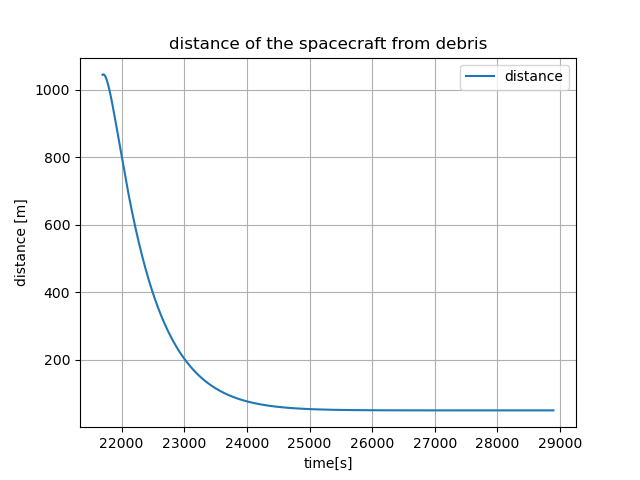

In [836]:
plt.figure()
plt.plot(time, np.sqrt(x_ctrl**2 + y_ctrl**2 +  z_ctrl**2), label = 'distance')

plt.xlabel('time[s]')
plt.ylabel('distance [m]')
plt.title('distance of the spacecraft from debris')
plt.legend()
plt.grid(True)

In [837]:
np.sqrt(x_ctrl**2 + y_ctrl**2 +  z_ctrl**2).min()

49.90559581021147

In [838]:
# Thus the minimum distance between spacecraft and debris is about 50 meters 
# so the above gains can be considered safe

In [839]:
time_propogation = time

In [840]:
time.shape

(144001,)

In [841]:
x_rk4.shape

(144001,)

In [842]:
F.shape

(144001,)

In [843]:
velocity_mag = np.sqrt(x_dot_rk4**2+y_dot_rk4**2+z_dot_rk4**2)
velocity_mag.shape

(144001,)

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# --- Downsample data ---
time = time_propogation[::20]
X1 = x_rk4[::20]
Y1 = y_rk4[::20]
Z1 = z_rk4[::20]
thrust = F[::20]
velocity = velocity_mag[::20]

# Ensure arrays are aligned
min_len = min(len(time), len(thrust), len(velocity), len(X1))
time = time[:min_len]
thrust = thrust[:min_len]
velocity = velocity[:min_len]
X1 = X1[:min_len]
Y1 = Y1[:min_len]
Z1 = Z1[:min_len]

# --- Set up figure ---
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Width and updated height for velocity/thrust plots
plot_width = 0.22
plot_height = 0.275  # Increased by 25%
plot_left = 0.08

# --- Velocity Plot (top) ---
ax_velocity = fig.add_axes([plot_left, 0.60, plot_width, plot_height])
ax_velocity.set_xlim(time[0]-500, time[-1]+500)
ax_velocity.set_ylim(np.min(velocity), 1.1)
ax_velocity.set_xlabel("Time (s)")
ax_velocity.set_ylabel("Velocity (m/s)")
ax_velocity.set_title("Velocity vs Time")
ax_velocity.grid(True)
velocity_line, = ax_velocity.plot([], [], 'r-', linewidth=2.0)

# --- Thrust Plot (bottom) ---
ax_thrust = fig.add_axes([plot_left, 0.19, plot_width, plot_height])
ax_thrust.set_xlim(time[0]-500, time[-1]+500)
ax_thrust.set_ylim(np.min(thrust), 4)
ax_thrust.set_xlabel("Time (s)")
ax_thrust.set_ylabel("Thrust (N)")
ax_thrust.set_title("Thrust vs Time")
ax_thrust.grid(True)
thrust_line, = ax_thrust.plot([], [], 'r-', linewidth=2.0)

# --- 3D Plot (unchanged in size/position) ---
ax = fig.add_axes([0.32, 0.1, 0.6, 0.8], projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title("Aprroaching at 50 Meters and Hold ", pad=1)  # Moved title downward

# Enlarged markers
ax.plot([0], [0], [0], 'go', markersize=10, label='Debris')
point1, = ax.plot([], [], [], 'ro', markersize=9, label='Spacecraft')
trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)

# Axis limits
ax.set_xlim(0, 300)
ax.set_ylim(-1000, 0)
ax.set_zlim(-20, 80)

# Moved legend to far right (but not off screen)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

# Global time title moved upward
title = fig.suptitle('', y=0.95)

# --- Update function ---
current_frame = [0]
is_animating = [True]

def update_frame(frame):
    point1.set_data(X1[frame], Y1[frame])
    point1.set_3d_properties(Z1[frame])
    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])

    thrust_line.set_data(time[:frame+1], thrust[:frame+1])
    velocity_line.set_data(time[:frame+1], velocity[:frame+1])

    title.set_text(f'Time = {time[frame]:.2f} sec')
    fig.canvas.draw_idle()

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)
    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- UI Controls ---
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time) - 1,
    step=1,
    description='Frame:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

toggle_button = widgets.ToggleButton(
    value=True,
    description='⏸ Pause',
    tooltip='Toggle animation',
    icon='pause'
)

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')

display(widgets.HBox([toggle_button, slider]))

# --- Save as Video ---
from matplotlib.animation import FFMpegWriter
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=450, metadata=dict(artist='Me'), bitrate=12000)
ani.save("spacecraft_animation_with_velocity_and_thrust.mp4", writer=writer)

print("Saved video as 'choreography.mp4'")


In [844]:
# From the plots, the spacecraft seems to have achieved desired position and velocity 
# The spacecraft is in hold position with respect to debris 

# Let's see what happens if control is removed at 28895 seconds 

# The values corresponding to time 28895 seconds are 

x0 = -0.052572327381049784
y0 = -49.978601748492025
z0 = 1.4247975642172033e-05
x_dot_0 = -1.8973999030185932e-05
y_dot_0 = -8.001602906405593e-05
z_dot_0 = -3.409353207387669e-08



In [845]:
# to see what happens if control is removed


def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x0
y=y0
z=z0
x_dot=x_dot_0
y_dot=y_dot_0
z_dot=z_dot_0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300+6395+9000+7200)

t_final=6300+6395+9000+7200+30000
points=int((t_final-6300-6395-9000-7200)/h)

# semi latus rectum
p=a_t*(1-e_t**2)


for i in range(points):
    
    Rc=Rc_vec[i+451900]
    Rc_dot=(Rc_vec[i+1+451900]-Rc_vec[i+451900])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
    time.append(6300+6395+9000+7200+(i+1)*h)
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)


time=np.array(time)

<IPython.core.display.Javascript object>


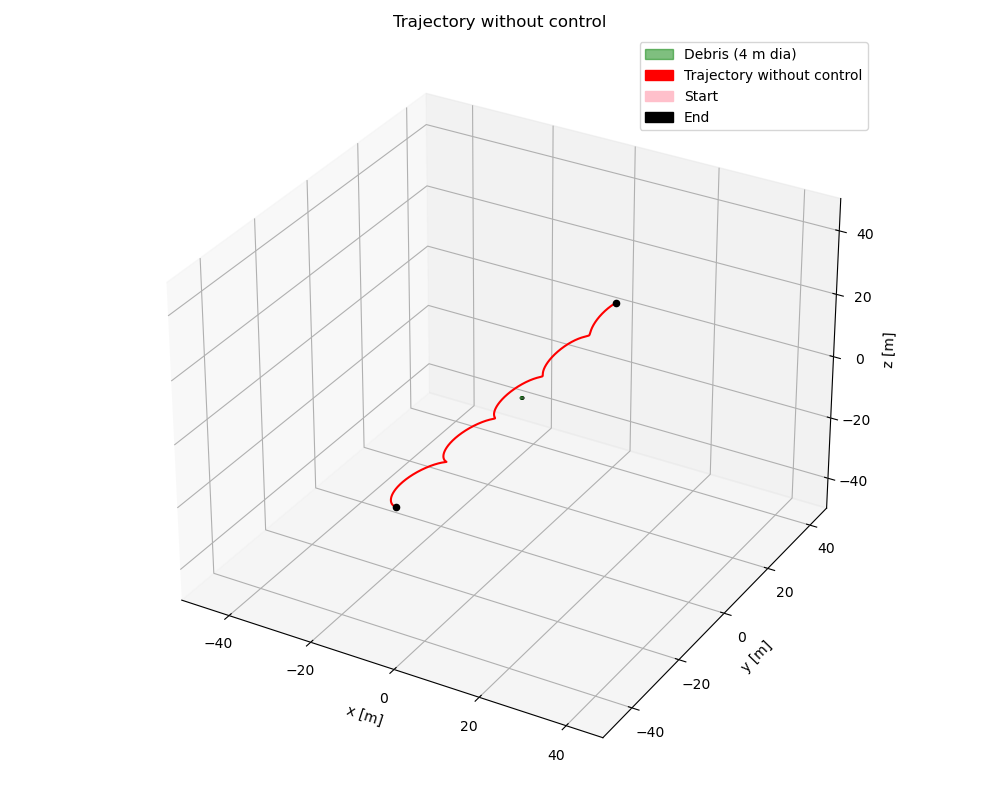

In [846]:
from matplotlib.patches import Patch

xwc, ywc, zwc = x_rk4, y_rk4, z_rk4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(xwc, ywc, zwc, label='Trajectory without control', color='red')
ax.scatter(xwc[0], ywc[0], zwc[0], color='black', marker='o', label='Start')
ax.scatter(xwc[-1], ywc[-1], zwc[-1], color='black', marker='o', label='End')

# Plot 3D debris sphere (radius = 2 m)
r = 0.5 
u, v = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
x_sphere = r * np.outer(np.cos(u), np.sin(v))
y_sphere = r * np.outer(np.sin(u), np.sin(v))
z_sphere = r * np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='green', alpha=0.5)

# Manual legend handle for the debris
legend_elements = [
    Patch(color='green', alpha=0.5, label='Debris (4 m dia)'),
    Patch(color='red', label='Trajectory without control'),
    Patch(color='pink', label='Start'),
    Patch(color='black', label='End')
]

# Labels and formatting
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Trajectory without control')
ax.grid(True)

# Equal aspect ratio scaling (including space for 2 m debris radius)
all_x = np.append(xwc, x_sphere.flatten())
all_y = np.append(ywc, y_sphere.flatten())
all_z = np.append(zwc, z_sphere.flatten())

x_range = all_x.max() - all_x.min()
y_range = all_y.max() - all_y.min()
z_range = all_z.max() - all_z.min()
max_range = max(x_range, y_range, z_range) / 2.0

mid_x = (all_x.max() + all_x.min()) / 2.0
mid_y = (all_y.max() + all_y.min()) / 2.0
mid_z = (all_z.max() + all_z.min()) / 2.0

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Add manual legend
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


In [847]:
np.sqrt(x_rk4**2 + y_rk4**2 +  z_rk4**2).min()

3.4103102323356467

In [848]:
# The above minimum distance indicates that there high risk of collision if control is removed 

In [849]:
# Aprroching the debris closer

# Let's manuver the spacecraft from (0, -50, 0 ) to (0, -10, 0) and hold it there 

# The values corresponding to time 28895 seconds are 

x0 = -0.052572327381049784
y0 = -49.978601748492025
z0 = 1.4247975642172033e-05
x_dot_0 = -1.8973999030185932e-05
y_dot_0 = -8.001602906405593e-05
z_dot_0 = -3.409353207387669e-08


In [850]:
# approaching closer to debris 


def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
    
    K1=0.0003
    P1=0.3
    
    K2=0.0001
    P2=0.2
    
    K3=0
    P3=0
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)-K1*(x-0)-P1*(x_dot-0)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)-K2*(y-(-10))-P2*(y_dot-0)
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)-K3*(z-0)-P3*(z_dot-0)

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x0
y=y0
z=z0
x_dot=x_dot_0
y_dot=y_dot_0
z_dot=z_dot_0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300+6395+9000+7200)

t_final=6300+6395+9000+7200+15000
points=int((t_final-6300-6395-9000-7200)/h)

# semi latus rectum
p=a_t*(1-e_t**2)

# for fuel cost

a_mag = []

for i in range(points):
    
    Rc=Rc_vec[i+451900]
    Rc_dot=(Rc_vec[i+1+451900]-Rc_vec[i+451900])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
     # for fuel cost
    
    a1 = (1/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    a2 = (1/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    a3 = (1/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    a_mag.append(np.sqrt(a1**2+a2**2+a3**2))
    
    
    time.append(6300+6395+9000+7200+(i+1)*h)
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)

a_mag=np.array(a_mag)
time=np.array(time)

<IPython.core.display.Javascript object>


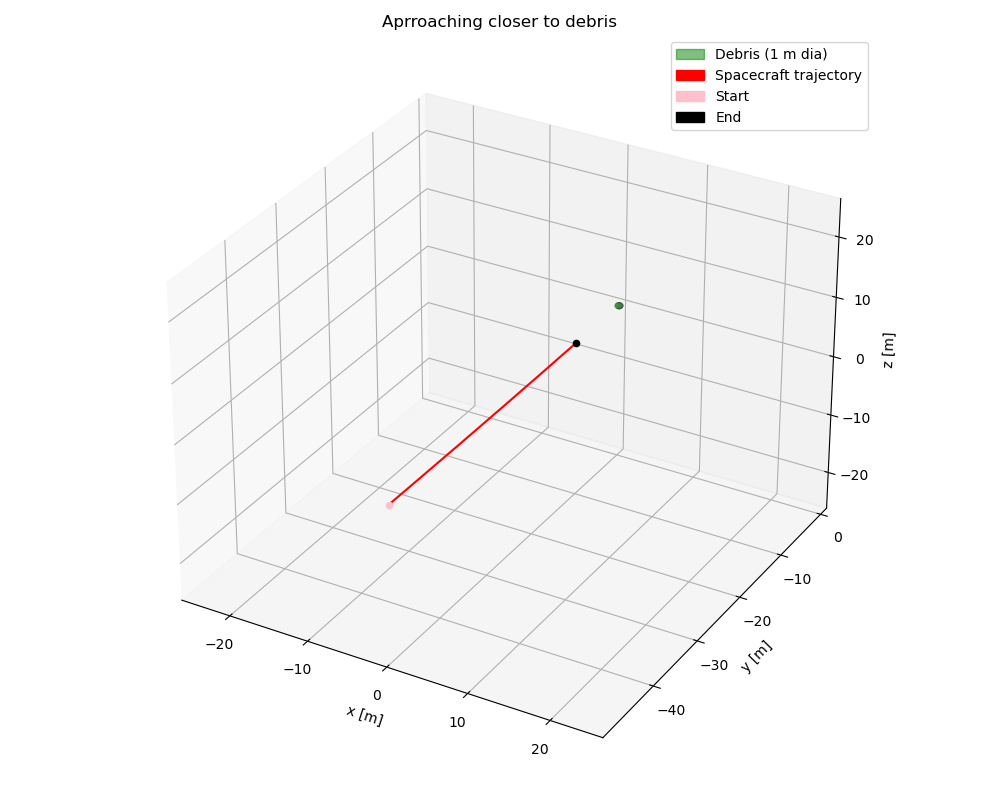

In [851]:
from matplotlib.patches import Patch

xc, yc, zc = x_rk4, y_rk4, z_rk4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(xc, yc, zc, label='Spacecraft trajectory', color='red')
ax.scatter(xc[0], yc[0], zc[0], color='pink', marker='o', label='Start')
ax.scatter(xc[-1], yc[-1], zc[-1], color='black', marker='o', label='End')

# Plot 3D debris sphere (radius = 0.5 m)
r = 0.5 
u, v = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
x_sphere = r * np.outer(np.cos(u), np.sin(v))
y_sphere = r * np.outer(np.sin(u), np.sin(v))
z_sphere = r * np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='green', alpha=0.5)

# Manual legend handle for the debris
legend_elements = [
    Patch(color='green', alpha=0.5, label='Debris (1 m dia)'),
    Patch(color='red', label='Spacecraft trajectory'),
    Patch(color='pink', label='Start'),
    Patch(color='black', label='End')
]

# Labels and formatting
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Aprroaching closer to debris')
ax.grid(True)

# Equal aspect ratio scaling (including space for 2 m debris radius)
all_x = np.append(xc, x_sphere.flatten())
all_y = np.append(yc, y_sphere.flatten())
all_z = np.append(zc, z_sphere.flatten())

x_range = all_x.max() - all_x.min()
y_range = all_y.max() - all_y.min()
z_range = all_z.max() - all_z.min()
max_range = max(x_range, y_range, z_range) / 2.0

mid_x = (all_x.max() + all_x.min()) / 2.0
mid_y = (all_y.max() + all_y.min()) / 2.0
mid_z = (all_z.max() + all_z.min()) / 2.0

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Add manual legend
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


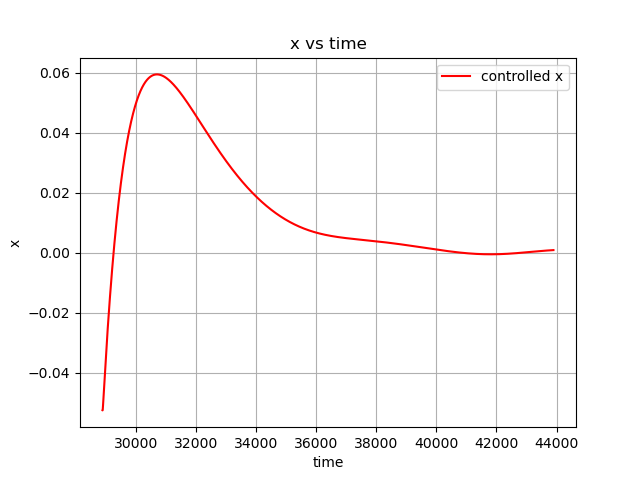

In [852]:
# x

plt.figure()
plt.plot(time, x_rk4, 'red', label='controlled x')

plt.xlabel('time')
plt.ylabel('x')
plt.title('x vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


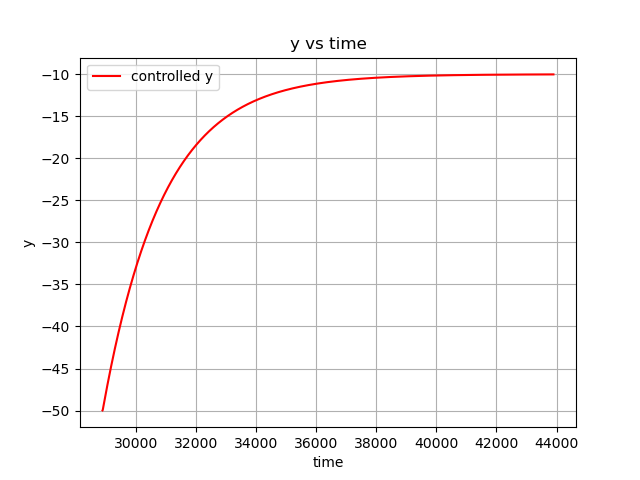

In [853]:
# y

plt.figure()
plt.plot(time, y_rk4, 'red', label='controlled y')

plt.xlabel('time')
plt.ylabel('y')
plt.title('y vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


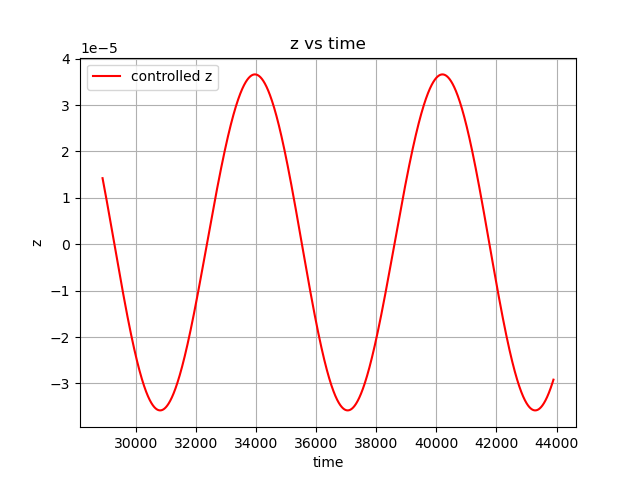

In [854]:
# z

plt.figure()
plt.plot(time, z_rk4, 'red', label='controlled z')

plt.xlabel('time')
plt.ylabel('z')
plt.title('z vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


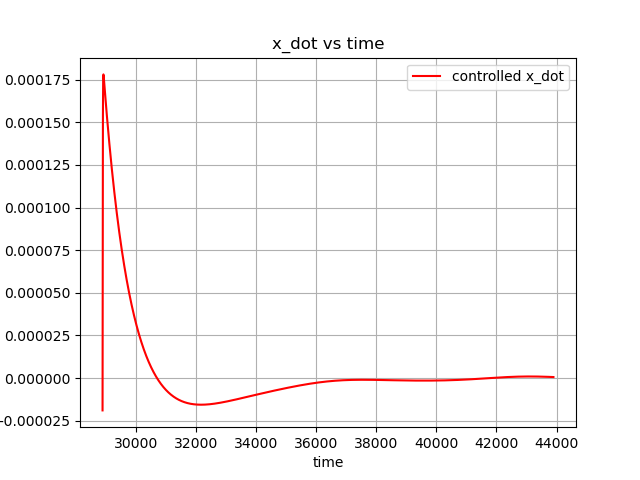

In [855]:
# x_dot

plt.figure()
plt.plot(time, x_dot_rk4, 'red', label='controlled x_dot')

plt.xlabel('time')
plt.ylabel('x_dot')
plt.title('x_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


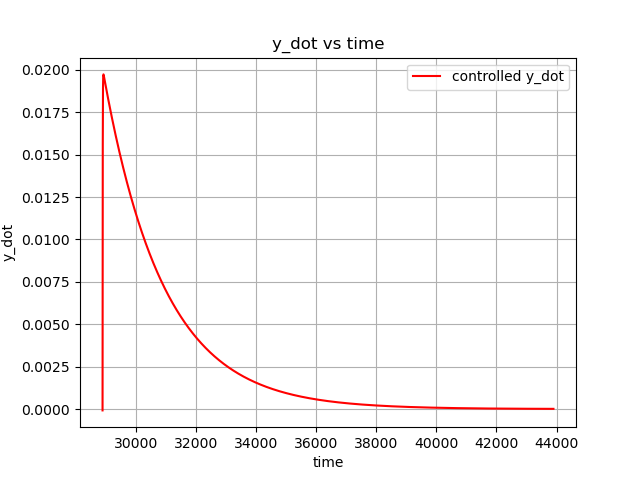

In [856]:
# y_dot

plt.figure()
plt.plot(time, y_dot_rk4, 'red', label='controlled y_dot')

plt.xlabel('time')
plt.ylabel('y_dot')
plt.title('y_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


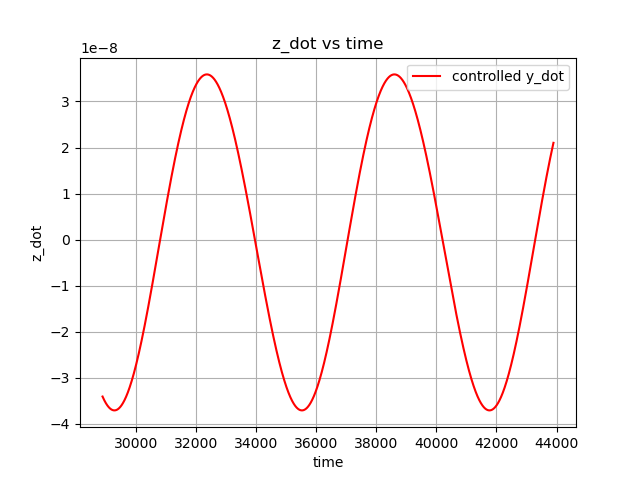

In [857]:
# z_dot
 
plt.figure()
plt.plot(time, z_dot_rk4, 'red', label='controlled y_dot')

plt.xlabel('time')
plt.ylabel('z_dot')
plt.title('z_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


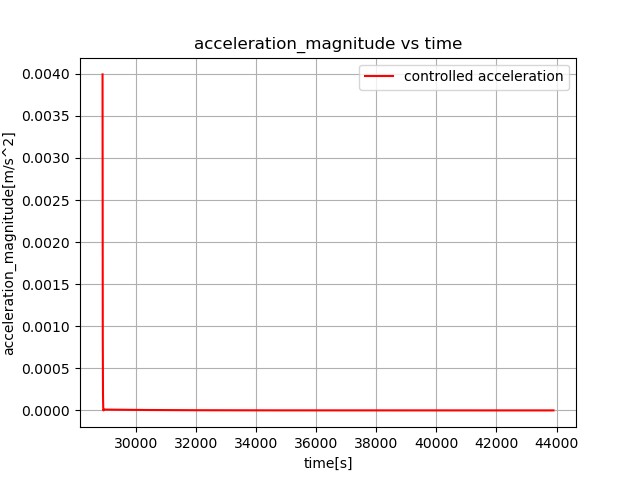

In [858]:
# a_mag

plt.figure()
plt.plot(time[:-1], a_mag, 'red', label='controlled acceleration')


plt.xlabel('time[s]')
plt.ylabel('acceleration_magnitude[m/s^2]')
plt.title('acceleration_magnitude vs time')
plt.legend()
plt.grid(True)

In [859]:
# Fuel cost calculation

# Inputs

a_mag = a_mag          # np.array of acceleration magnitudes [m/s²], one per time step
dt = h                 # time step [s]
Isp = 300              # specific impulse [s]
g0 = 9.80665           # standard gravity [m/s²]
m0 = 191.10635701272346               # initial mass [kg]

# Initialize
mass = [m0]

# Loop through time
F=[]
for a in a_mag:
    m = mass[-1]
    thrust = m * a                             # F = m*a
    mdot = thrust / (Isp * g0)                 # ṁ = F / (Isp * g₀)
    m_new = m - mdot * dt                      # new mass after burning
    mass.append(m_new)
    F.append(thrust)

# Final results

m_final = mass[-1]
delta_m = m0 - m_final

print('initial mass of spacecraft is ',m0 ,'kg')
print('final mass of spacecraft is ',m_final ,'kg')
print('fuel consumed is', delta_m, 'kg')


initial mass of spacecraft is  191.10635701272346 kg
final mass of spacecraft is  191.10378850830267 kg
fuel consumed is 0.0025685044207932606 kg


In [860]:
F.append(9.0387e-07)

In [861]:
np.array(F).shape

(300001,)

In [862]:
time.shape

(300001,)

<IPython.core.display.Javascript object>


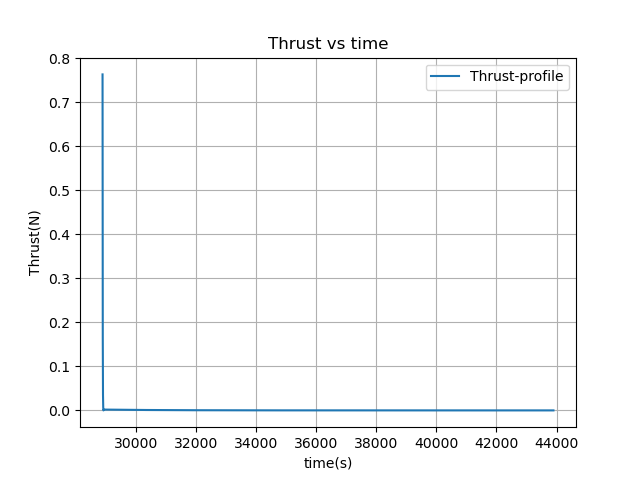

In [863]:
F=np.array(F)

plt.figure()
plt.plot(time, F, label='Thrust-profile')

plt.xlabel('time(s)')
plt.ylabel('Thrust(N)')
plt.title('Thrust vs time')
plt.legend()
plt.grid(True)

In [864]:
x_rk4[-1]

0.0008588822097765314

In [865]:
y_rk4[-1]

-10.02257868526189

In [866]:
z_rk4[-1]

-2.9196860305464413e-05

In [867]:
x_dot_rk4[-1]

5.79489283172912e-07

In [868]:
y_dot_rk4[-1]

1.1361426928150506e-05

In [869]:
z_dot_rk4[-1]

2.1021905042097293e-08

In [870]:
time[-1]

43895.0

<IPython.core.display.Javascript object>


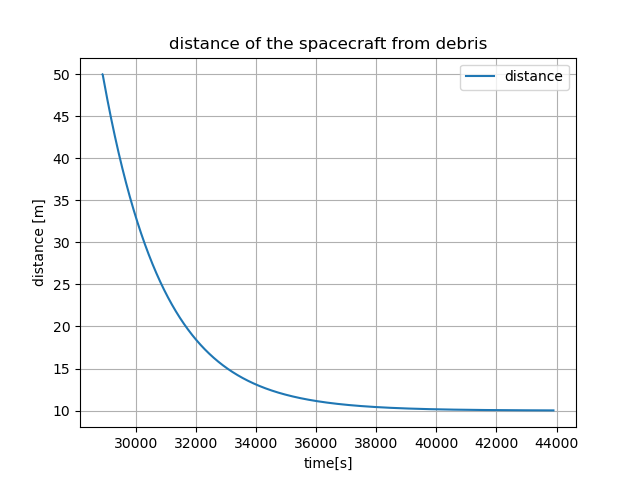

In [871]:
plt.figure()
plt.plot(time, np.sqrt(x_rk4**2 + y_rk4**2 +  z_rk4**2), label = 'distance')

plt.xlabel('time[s]')
plt.ylabel('distance [m]')
plt.title('distance of the spacecraft from debris')
plt.legend()
plt.grid(True)

In [872]:
np.sqrt(x_rk4**2 + y_rk4**2 +  z_rk4**2).min()

10.022578722105257

In [873]:
# Thus spacecraft doesnot go closer than 10 meters 

In [874]:
velocity_mag = np.sqrt(x_dot_rk4**2+y_dot_rk4**2+z_dot_rk4**2)
velocity_mag.shape

(300001,)

In [875]:
x_rk4.shape

(300001,)

In [876]:
time_propogation = time

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# --- Downsample data ---
time = time_propogation[::20]
X1 = x_rk4[::20]
Y1 = y_rk4[::20]
Z1 = z_rk4[::20]
thrust = F[::20]
velocity = velocity_mag[::20]

# Ensure arrays are aligned
min_len = min(len(time), len(thrust), len(velocity), len(X1))
time = time[:min_len]
thrust = thrust[:min_len]
velocity = velocity[:min_len]
X1 = X1[:min_len]
Y1 = Y1[:min_len]
Z1 = Z1[:min_len]

# --- Set up figure ---
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Width and updated height for velocity/thrust plots
plot_width = 0.22
plot_height = 0.275  # Increased by 25%
plot_left = 0.08

# --- Velocity Plot (top) ---
ax_velocity = fig.add_axes([plot_left, 0.60, plot_width, plot_height])
ax_velocity.set_xlim(time[0]-500, time[-1]+500)
ax_velocity.set_ylim(np.min(velocity), 0.021)
ax_velocity.set_xlabel("Time (s)")
ax_velocity.set_ylabel("Velocity (m/s)")
ax_velocity.set_title("Velocity vs Time")
ax_velocity.grid(True)
velocity_line, = ax_velocity.plot([], [], 'r-', linewidth=2.0)

# --- Thrust Plot (bottom) ---
ax_thrust = fig.add_axes([plot_left, 0.19, plot_width, plot_height])
ax_thrust.set_xlim(time[0]-500, time[-1]+500)
ax_thrust.set_ylim(np.min(thrust), 0.8)
ax_thrust.set_xlabel("Time (s)")
ax_thrust.set_ylabel("Thrust (N)")
ax_thrust.set_title("Thrust vs Time")
ax_thrust.grid(True)
thrust_line, = ax_thrust.plot([], [], 'r-', linewidth=2.0)

# --- 3D Plot (unchanged in size/position) ---
ax = fig.add_axes([0.32, 0.1, 0.6, 0.8], projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title("Approaching at 10 Meters and Hold ", pad=1)  # Moved title downward

# Enlarged markers
ax.plot([0], [0], [0], 'go', markersize=10, label='Debris')
point1, = ax.plot([], [], [], 'ro', markersize=9, label='Spacecraft')
trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)

# Axis limits
ax.set_xlim(-20, 20)
ax.set_ylim(-50, 0)
ax.set_zlim(-20, 20)

# Moved legend to far right (but not off screen)
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

# Global time title moved upward
title = fig.suptitle('', y=0.95)

# --- Update function ---
current_frame = [0]
is_animating = [True]

def update_frame(frame):
    point1.set_data(X1[frame], Y1[frame])
    point1.set_3d_properties(Z1[frame])
    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])

    thrust_line.set_data(time[:frame+1], thrust[:frame+1])
    velocity_line.set_data(time[:frame+1], velocity[:frame+1])

    title.set_text(f'Time = {time[frame]:.2f} sec')
    fig.canvas.draw_idle()

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)
    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- UI Controls ---
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(time) - 1,
    step=1,
    description='Frame:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

toggle_button = widgets.ToggleButton(
    value=True,
    description='⏸ Pause',
    tooltip='Toggle animation',
    icon='pause'
)

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')

display(widgets.HBox([toggle_button, slider]))

# --- Save as Video ---
from matplotlib.animation import FFMpegWriter
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=900, metadata=dict(artist='Me'), bitrate=24000)
ani.save("spacecraft_animation_with_velocity_and_thrust.mp4", writer=writer)

print("Saved video as 'choreography.mp4'")


In [877]:
# The spacecraft is at rest with respect to debris 
# The spacecraft position with respect to debris is (0, -10, 0)

# Attitude dynamics of debris  

# The debris is tumbling
# The fixed (Hill frame) is attached to debris, with origin (0,0,0) at centre of mass of debris.
# let's attach another body frame to debris rigidly such that the origin of this body frame is at the cm of debris

# The initial time is 43895 seconds

# The initial body angular velocity of debris is ( components expressed in body frame)

w_debris = np.radians(np.array([-1.47740552 , 1.94418903,  1.74281438]))   # rad/s

# The initial orientation of the above rotating debris frame with respect to fixed hill frame is given as 
# 3-2-1 , yaw-pitch-roll, (psi = 56 degrees, theta = 13 degrees, phi = 27 degrees)

psi = np.radians(56)
theta  = np.radians(13)
phi = np.radians(27)

# The initial direction cosine matrix is

C = np.array([[ 0.54486083,  0.80778939, -0.22495105],
              [-0.68156995,  0.58291052,  0.44235475],
              [ 0.48845581, -0.0877019 ,  0.86817008]])


# The initial modified rodrigues parameters (mrp) are

sigma = np.array([0.08208135, 0.11047385, 0.23063313])

# moment of inertia tensor of debris

I=np.array([[10,  0,  0],
            [ 0,  8,  0],
            [ 0,  0,  12]])

# Torque acting on debris (Assuming torque free debris motion)

L=np.array([0,0,0])

In [878]:
# Analyzing rotational motion of debris

Ixx=10
Iyy=8
Izz=12

w1=w_debris[0]
w2=w_debris[1]
w3=w_debris[2]

sigma1=sigma[0]
sigma2=sigma[1]
sigma3=sigma[2]

L1=L[0]
L2=L[1]
L3=L[2]

# appending initial values  

sigma_propogation=[]
sigma_propogation.append(sigma)

w_propogation=[]
w_propogation.append(w_debris)

time=[]
time.append(6300+6395+9000+7200+15000)

t_final=6300+6395+9000+7200+15000+8500
points=int((t_final-6300-6395-9000-7200-15000)/h)


def derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3):
    
    sigma1_dot=1/4*((1-sigma1**2-sigma2**2-sigma3**2+2*sigma1**2)*w1 + 2*(sigma1*sigma2-sigma3)*w2 + 2*(sigma1*sigma3+sigma2)*w3)
    sigma2_dot=1/4*(2*(sigma1*sigma2+sigma3)*w1 + (1-sigma1**2-sigma2**2-sigma3**2+2*sigma2**2)*w2 + 2*(sigma2*sigma3-sigma1)*w3)
    sigma3_dot=1/4*(2*(sigma1*sigma3-sigma2)*w1 + 2*(sigma2*sigma3+sigma1)*w2 + (1-sigma1**2-sigma2**2-sigma3**2+2*sigma3**2)*w3)
    
    w1_dot = L1 - ((Izz-Iyy)/(Ixx))*w2*w3
    w2_dot = L2 - ((Ixx-Izz)/(Iyy))*w3*w1
    w3_dot = L3 - ((Iyy-Ixx)/(Izz))*w1*w2
    
    return (sigma1_dot,sigma2_dot,sigma3_dot, w1_dot,w2_dot,w3_dot)


for i in range(points):
    
    # k1
    
    k1_sigma1=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k1_sigma2=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k1_sigma3=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k1_w1=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k1_w2=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k1_w3=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k2
    
    k2_sigma1=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k2_sigma2=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k2_sigma3=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k2_w1=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k2_w2=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k2_w3=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k3
    
    k3_sigma1=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k3_sigma2=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k3_sigma3=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k3_w1=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k3_w2=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k3_w3=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k4
    
    k4_sigma1=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k4_sigma2=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k4_sigma3=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k4_w1=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k4_w2=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k4_w3=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    
    sigma1=sigma1+(h/6)*(k1_sigma1+2*k2_sigma1+2*k3_sigma1+k4_sigma1)
    sigma2=sigma2+(h/6)*(k1_sigma2+2*k2_sigma2+2*k3_sigma2+k4_sigma2)
    sigma3=sigma3+(h/6)*(k1_sigma3+2*k2_sigma3+2*k3_sigma3+k4_sigma3)
    w1=w1+(h/6)*(k1_w1+2*k2_w1+2*k3_w1+k4_w1)
    w2=w2+(h/6)*(k1_w2+2*k2_w2+2*k3_w2+k4_w2)
    w3=w3+(h/6)*(k1_w3+2*k2_w3+2*k3_w3+k4_w3)
    
    norm=np.linalg.norm(np.array([sigma1,sigma2,sigma3]))
    
    if norm > 1:
        sigma1=(-sigma1)/norm**2
        sigma2=(-sigma2)/norm**2
        sigma3=(-sigma3)/norm**2
    
    sigma_propogation.append(np.array([sigma1,sigma2,sigma3]))
    w_propogation.append(np.array([w1,w2,w3]))
    time.append(6300+6395+9000+7200+15000+(i+1)*h)

sigma_debris = np.array(sigma_propogation)
w_debris = np.array(w_propogation)
time = np.array(time)


<IPython.core.display.Javascript object>


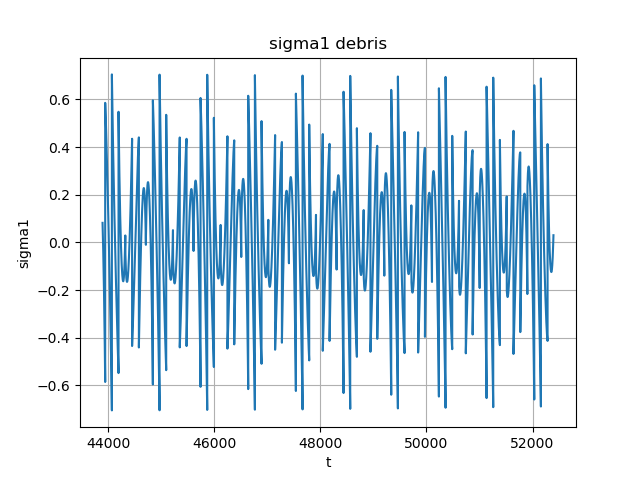

In [879]:
 # Plotting sigma propogation and omega propogation of debris object

t=time

plt.figure()
plt.plot(t, sigma_debris[:,0])
plt.xlabel("t")
plt.ylabel("sigma1")
plt.title("sigma1 debris")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


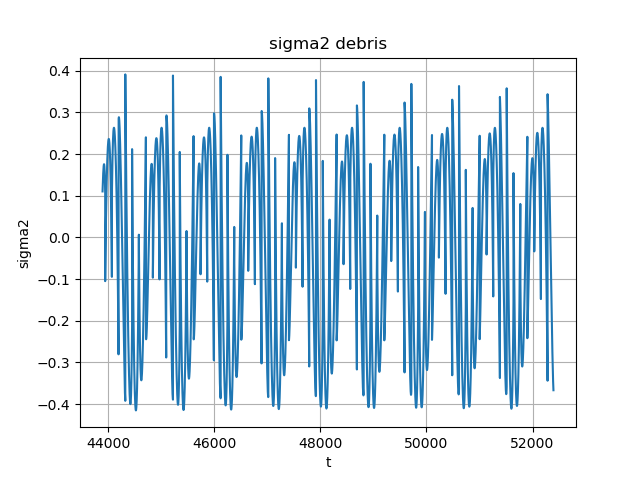

In [880]:
plt.figure()
plt.plot(t, sigma_debris[:,1])
plt.xlabel("t")
plt.ylabel("sigma2")
plt.title("sigma2 debris")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


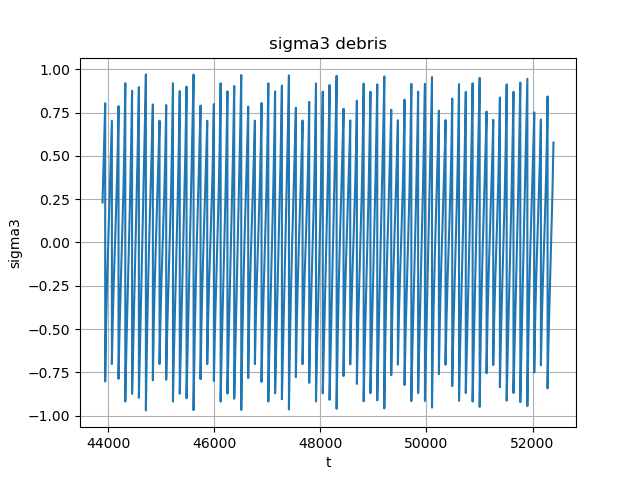

In [881]:
plt.figure()
plt.plot(t, sigma_debris[:,2])
plt.xlabel("t")
plt.ylabel("sigma3")
plt.title("sigma3 debris")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


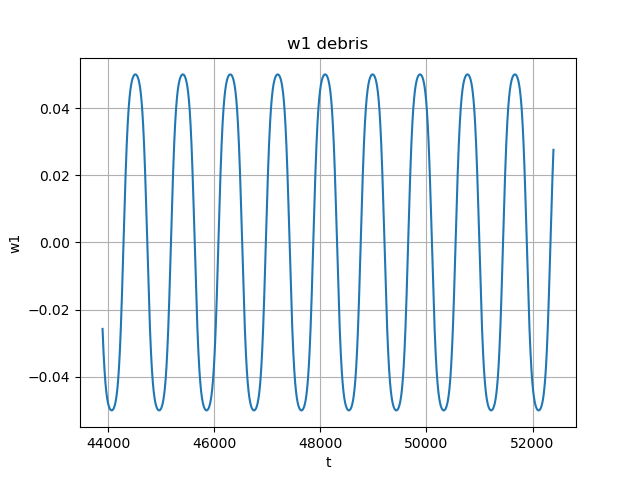

In [882]:
plt.figure()
plt.plot(t, w_debris[:,0])
plt.xlabel("t")
plt.ylabel("w1")
plt.title("w1 debris")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


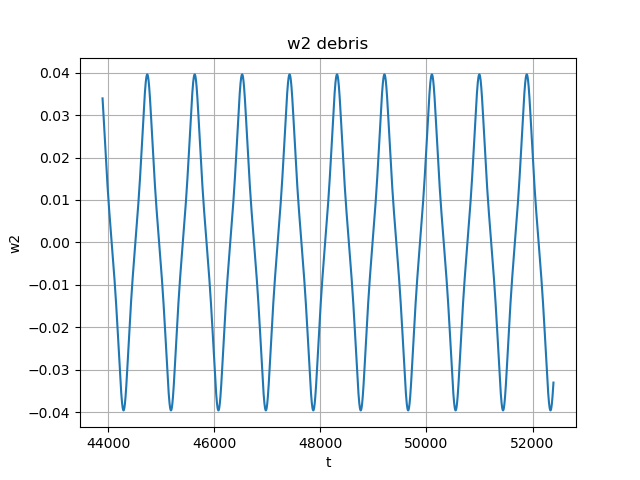

In [883]:
plt.figure()
plt.plot(t, w_debris[:,1])
plt.xlabel("t")
plt.ylabel("w2")
plt.title("w2 debris")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


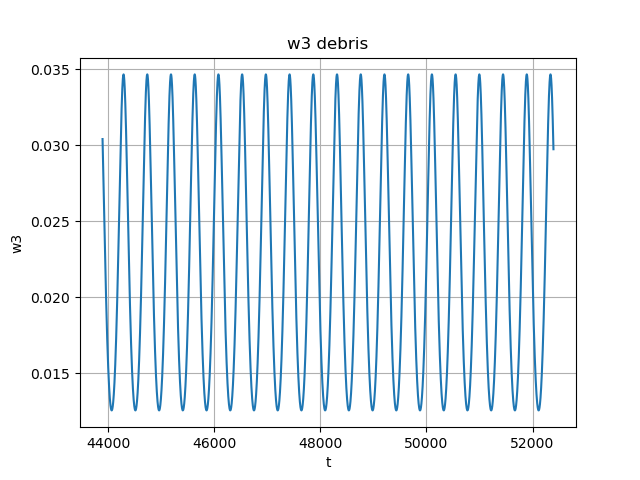

In [884]:
plt.figure()
plt.plot(t, w_debris[:,2])
plt.xlabel("t")
plt.ylabel("w3")
plt.title("w3 debris")
plt.grid()
plt.show()


In [885]:
# Let's rotate the spacecraft so that the angular motion of spacecrarft matches with that of debris
# Let's attach a body frame rigidly to the spacecraft
# The origin of this body frame is at the centre of mass of spacecraft

# The initial time is 43895 seconds 

# The initial orientation of spaceraft with respect to fixed hill frame is given as 
# 3-2-1 , yaw-pitch-roll, (psi = 78 degrees, theta = 32 degrees, phi = 48)

psi = np.radians(78)
theta  = np.radians(32)
phi = np.radians(48)

# The initial direction cosine matrix is

C = np.array([[ 0.176319,  0.829516, -0.529919],
              [-0.572631,  0.524321,  0.630223],
              [ 0.800628,  0.192328,  0.567455]])


# The initial modified rodrigues parameters (mrp) are

sigma = np.array([0.08293255, 0.25199113, 0.2655514])


# Initial angular velocity of the spacecraft is (components expressed in spacecraft body frame) 

w_spacecraft = np.radians(np.array([0, 0, 0]))


# moment of inertia tensor of spacecraft

I=np.array([[10,  0,  0],
            [ 0,  20,  0],
            [ 0,  0,  25]])

In [886]:
# Rotating the spacecraft and matching with debris angular motion

Ixx=10
Iyy=20
Izz=25

w1=0
w2=0
w3=0

sigma1=0.08293255
sigma2=0.25199113
sigma3=0.2655514

# initial torque on the spacecraft

K1= 0.008
P1= 1

K2= 0.016
P2= 2

K3= 0.02
P3= 0.7

L1=-K1*(sigma1-sigma_debris[:,0][0])-P1*(w1-w_debris[:,0][0])
L2=-K2*(sigma2-sigma_debris[:,1][0])-P2*(w2-w_debris[:,1][0])
L3=-K3*(sigma3-sigma_debris[:,2][0])-P3*(w3-w_debris[:,2][0])

# appending initial values  

sigma_propogation=[]
sigma_propogation.append(sigma)

w_propogation=[]
w_propogation.append(w_spacecraft)

L_propogation=[]
L_propogation.append(np.array([L1, L2, L3]))

time=[]
time.append(6300+6395+9000+7200+15000)

t_final=6300+6395+9000+7200+15000+8500
points=int((t_final-6300-6395-9000-7200-15000)/h)


def derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3):
    
    sigma1_dot=1/4*((1-sigma1**2-sigma2**2-sigma3**2+2*sigma1**2)*w1 + 2*(sigma1*sigma2-sigma3)*w2 + 2*(sigma1*sigma3+sigma2)*w3)
    sigma2_dot=1/4*(2*(sigma1*sigma2+sigma3)*w1 + (1-sigma1**2-sigma2**2-sigma3**2+2*sigma2**2)*w2 + 2*(sigma2*sigma3-sigma1)*w3)
    sigma3_dot=1/4*(2*(sigma1*sigma3-sigma2)*w1 + 2*(sigma2*sigma3+sigma1)*w2 + (1-sigma1**2-sigma2**2-sigma3**2+2*sigma3**2)*w3)
    
    w1_dot = L1 - ((Izz-Iyy)/(Ixx))*w2*w3
    w2_dot = L2 - ((Ixx-Izz)/(Iyy))*w3*w1
    w3_dot = L3 - ((Iyy-Ixx)/(Izz))*w1*w2
    
    return (sigma1_dot,sigma2_dot,sigma3_dot, w1_dot,w2_dot,w3_dot)


for i in range(points):
    
    # k1
    
    k1_sigma1=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k1_sigma2=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k1_sigma3=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k1_w1=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k1_w2=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k1_w3=derivatives(sigma1, sigma2, sigma3, w1, w2, w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k2
    
    k2_sigma1=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k2_sigma2=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k2_sigma3=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k2_w1=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k2_w2=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k2_w3=derivatives(sigma1+(h/2)*k1_sigma1, sigma2+(h/2)*k1_sigma2, sigma3+(h/2)*k1_sigma3, w1+(h/2)*k1_w1, w2+(h/2)*k1_w2, w3+(h/2)*k1_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k3
    
    k3_sigma1=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k3_sigma2=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k3_sigma3=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k3_w1=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k3_w2=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k3_w3=derivatives(sigma1+(h/2)*k2_sigma1, sigma2+(h/2)*k2_sigma2, sigma3+(h/2)*k2_sigma3, w1+(h/2)*k2_w1, w2+(h/2)*k2_w2, w3+(h/2)*k2_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    # k4
    
    k4_sigma1=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[0]
    k4_sigma2=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[1]
    k4_sigma3=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[2]
    k4_w1=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[3]
    k4_w2=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[4]
    k4_w3=derivatives(sigma1+(h)*k3_sigma1, sigma2+(h)*k3_sigma2, sigma3+(h)*k3_sigma3, w1+(h)*k3_w1, w2+(h)*k3_w2, w3+(h)*k3_w3, Ixx, Iyy, Izz, L1, L2, L3)[5]
    
    
    sigma1=sigma1+(h/6)*(k1_sigma1+2*k2_sigma1+2*k3_sigma1+k4_sigma1)
    sigma2=sigma2+(h/6)*(k1_sigma2+2*k2_sigma2+2*k3_sigma2+k4_sigma2)
    sigma3=sigma3+(h/6)*(k1_sigma3+2*k2_sigma3+2*k3_sigma3+k4_sigma3)
    w1=w1+(h/6)*(k1_w1+2*k2_w1+2*k3_w1+k4_w1)
    w2=w2+(h/6)*(k1_w2+2*k2_w2+2*k3_w2+k4_w2)
    w3=w3+(h/6)*(k1_w3+2*k2_w3+2*k3_w3+k4_w3)
    
    norm=np.linalg.norm(np.array([sigma1,sigma2,sigma3]))
    
    if norm > 1:
        sigma1=(-sigma1)/norm**2
        sigma2=(-sigma2)/norm**2
        sigma3=(-sigma3)/norm**2
        
    L1=-K1*(sigma1-sigma_debris[:,0][i+1])-P1*(w1-w_debris[:,0][i+1])
    L2=-K2*(sigma2-sigma_debris[:,1][i+1])-P2*(w2-w_debris[:,1][i+1])
    L3=-K3*(sigma3-sigma_debris[:,2][i+1])-P3*(w3-w_debris[:,2][i+1])
    
    sigma_propogation.append(np.array([sigma1,sigma2,sigma3]))
    w_propogation.append(np.array([w1,w2,w3]))
    L_propogation.append(np.array([L1,L2,L3]))
    time.append(6300+6395+9000+7200+15000+(i+1)*h)

sigma_spacecraft = np.array(sigma_propogation)
w_spacecraft = np.array(w_propogation)
L_spacecraft = np.array(L_propogation)
time = np.array(time)



<IPython.core.display.Javascript object>


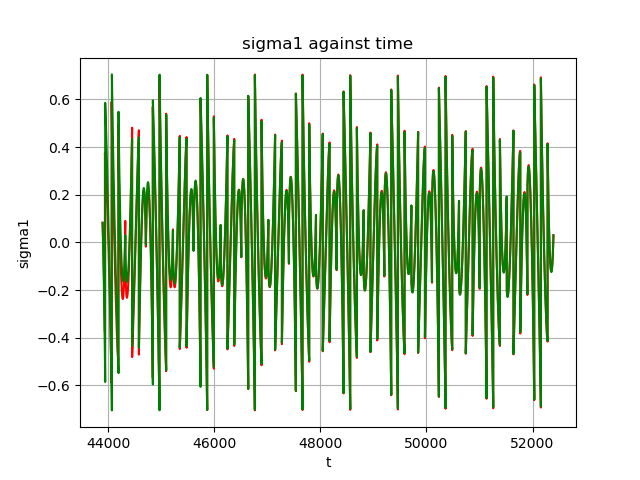

In [887]:
t=time

plt.figure()
plt.plot(t, sigma_spacecraft[:,0], 'red')
plt.plot(t, sigma_debris[:,0], 'green')
plt.xlabel("t")
plt.ylabel("sigma1")
plt.title("sigma1 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


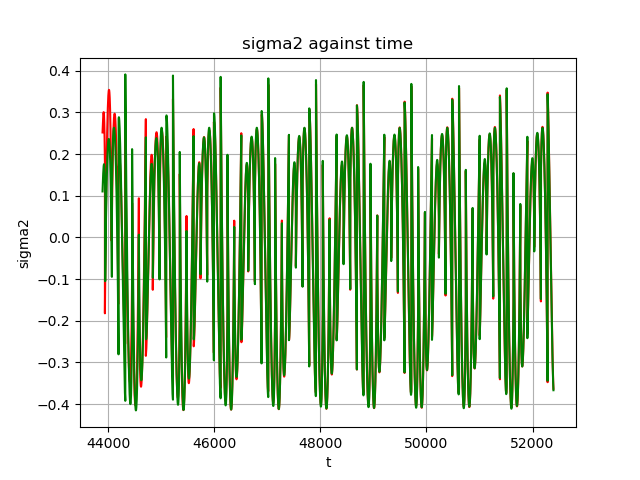

In [888]:
plt.figure()
plt.plot(t, sigma_spacecraft[:,1], 'red')
plt.plot(t, sigma_debris[:,1], 'green')
plt.xlabel("t")
plt.ylabel("sigma2")
plt.title("sigma2 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


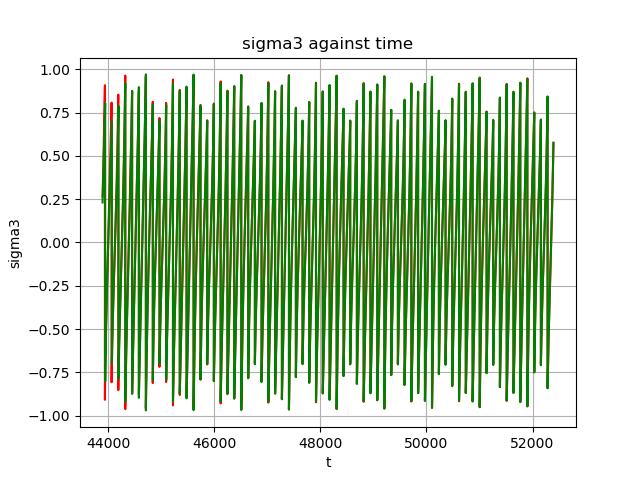

In [889]:
plt.figure()
plt.plot(t, sigma_spacecraft[:,2], 'red')
plt.plot(t, sigma_debris[:,2], 'green')
plt.xlabel("t")
plt.ylabel("sigma3")
plt.title("sigma3 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


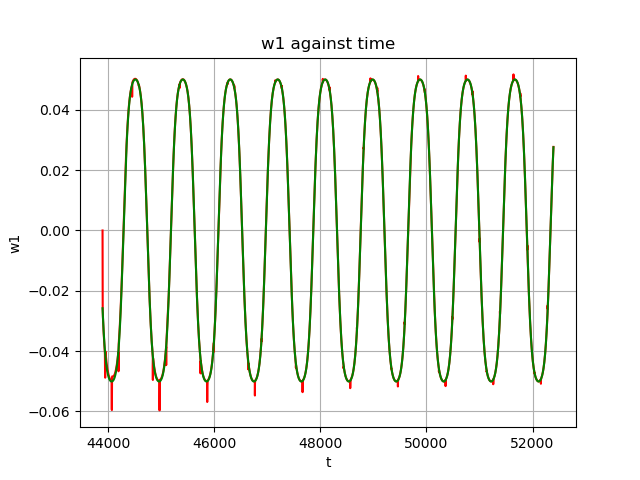

In [890]:
plt.figure()
plt.plot(t, w_spacecraft[:,0], 'red')
plt.plot(t, w_debris[:,0], 'green')
plt.xlabel("t")
plt.ylabel("w1")
plt.title("w1 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


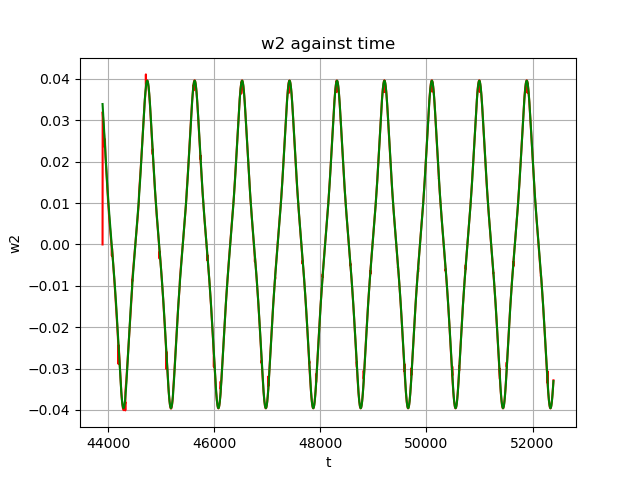

In [891]:
plt.figure()
plt.plot(t, w_spacecraft[:,1], 'red')
plt.plot(t, w_debris[:,1], 'green')
plt.xlabel("t")
plt.ylabel("w2")
plt.title("w2 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


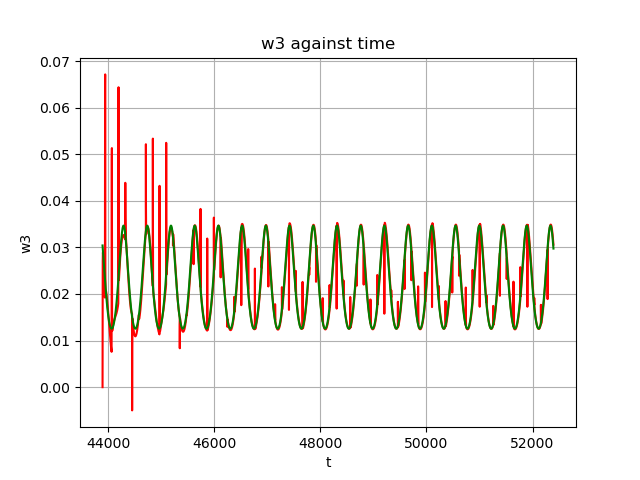

In [892]:
plt.figure()
plt.plot(t, w_spacecraft[:,2], 'red')
plt.plot(t, w_debris[:,2], 'green')
plt.xlabel("t")
plt.ylabel("w3")
plt.title("w3 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


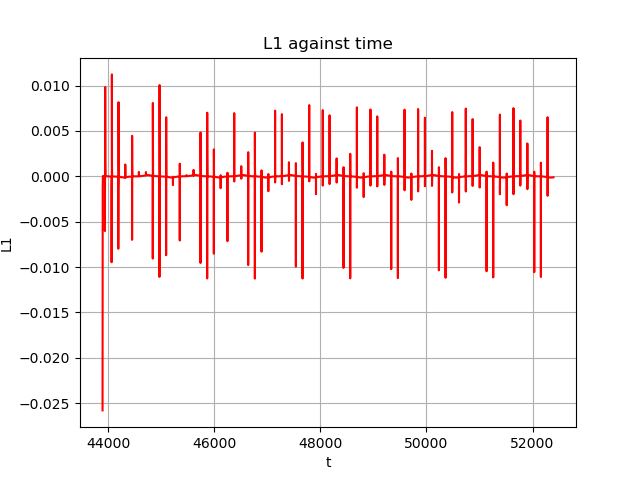

In [893]:
plt.figure()
plt.plot(t, L_spacecraft[:,0], 'red')
plt.xlabel("t")
plt.ylabel("L1")
plt.title("L1 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


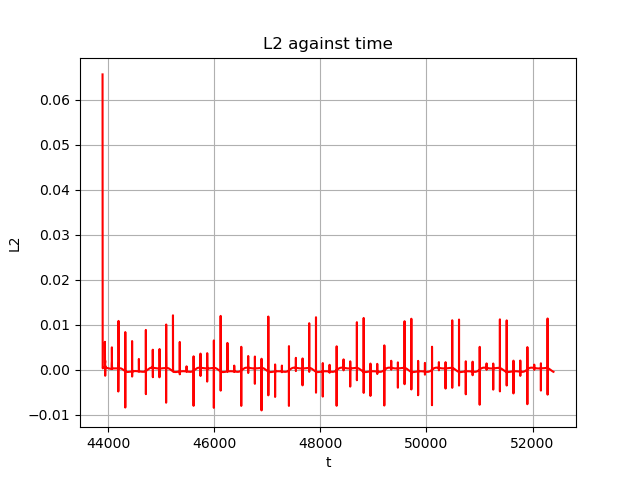

In [894]:
plt.figure()
plt.plot(t, L_spacecraft[:,1], 'red')
plt.xlabel("t")
plt.ylabel("L2")
plt.title("L2 against time")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


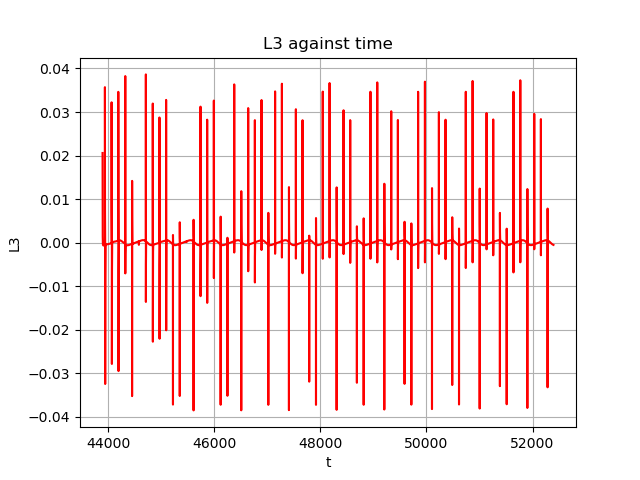

In [895]:
plt.figure()
plt.plot(t, L_spacecraft[:,2], 'red')
plt.xlabel("t")
plt.ylabel("L3")
plt.title("L3 against time")
plt.grid()
plt.show()

In [896]:
w_debris[-1]

array([ 0.0275985 , -0.03302918,  0.02974761])

In [897]:
w_spacecraft[-1]

array([ 0.02771095, -0.03284236,  0.03059298])

In [898]:
sigma_debris[-1]

array([ 0.03020863, -0.36655968,  0.57647195])

In [899]:
sigma_spacecraft[-1]

array([ 0.0298071 , -0.36314376,  0.57256597])

In [900]:
# function to calculate direction cosine matrix from given modified rodrigues parameters

def dcm_from_mrp(sigma):
    
    sigma1=sigma[0]
    sigma2=sigma[1]
    sigma3=sigma[2]
    norm=np.linalg.norm(np.array([sigma1,sigma2,sigma3]))
    
    if norm > 1:
        sigma1=(-sigma1)/norm**2
        sigma2=(-sigma2)/norm**2
        sigma3=(-sigma3)/norm**2
        
    sigma_squared=sigma1**2+sigma2**2+sigma3**2
    
    sigma_telda=np.array([
        [0,  -sigma3,  sigma2],
        [sigma3,  0,  -sigma1],
        [ -sigma2,  sigma1,  0]])
    
    sigma_telda_squared=sigma_telda @ sigma_telda
    
    DCM=np.eye(3)+(8* sigma_telda_squared-4*(1-sigma_squared)*sigma_telda)/((1+sigma_squared)**2)
    
    return (DCM)

In [901]:
sigma_debris.shape

(170001, 3)

In [902]:
sigma_spacecraft.shape

(170001, 3)

In [903]:
w_debris.shape

(170001, 3)

In [904]:
sigma_debris[0]

array([0.08208135, 0.11047385, 0.23063313])

In [905]:
# Calculating dcms of spacecarft and debris

C_debris = []
C_spacecraft = []

for i in range(170001):
    
    C_debris.append(dcm_from_mrp(sigma_debris[i]))
    C_spacecraft.append(dcm_from_mrp(sigma_spacecraft[i]))
    
C_debris = np.array(C_debris)
C_spacecraft = np.array(C_spacecraft)

In [906]:
# From dcm, the yaw-pitch-roll angles can be calculated as 

# initial yaw-pitch-roll angles of debris body frame : [55.99999994 13.00000014 27.00000028] degrees
# initial yaw-pitch-roll angles of spaceraft body frame : [77.99998359 31.99999614 48.00001981] degrees
# final yaw-pitch-roll angles of debris body frame : [-35.79518788 -25.28471341 -56.61564945] degrees
# final yaw-pitch-roll angles of spacecrfat body frame : [-36.64504214 -25.54870835 -56.1814503 ] degrees

In [907]:
# angular velocities 

print('initial angular velocity of debris body frame :', np.degrees(w_debris[0]) , 'deg/s' )
print('initial angular velocity of spaceraft body frame :', np.degrees(w_spacecraft[0]) , 'deg/s')
print('final angular velocity of debris body frame :', np.degrees(w_debris[-1]) , 'deg/s' )
print('final angular velocity of spacecraft body frame :', np.degrees(w_spacecraft[-1]) , 'deg/s')


initial angular velocity of debris body frame : [-1.47740552  1.94418903  1.74281438] deg/s
initial angular velocity of spaceraft body frame : [0. 0. 0.] deg/s
final angular velocity of debris body frame : [ 1.58127746 -1.89243267  1.70441258] deg/s
final angular velocity of spacecraft body frame : [ 1.58772063 -1.88172879  1.75284855] deg/s


In [908]:
# final manuver

# let's move the spacecraft from (0, -10 , 0) to (0, -3, 0) 
# The spacecrfat speed in the y-direction would be 2 mm/sec
# Hence, the time of manuver is 3500 seconds

# The manuver starts at 48895 seconds 
# Tha manuver ends at 48895 +3500 = 52395 seconds 

# The maximum dimension of debris is ( diameter = 1 meter)
# The maximum dimension of spacecraft is 1 meter (say, length )

# The final distance of 3 meters is the distance between the cm of debris and cm of spaceraft

def y_desired(i):
    
    t=i*h
    
    y_desired = -10 + (0.002) * t
    y_dot_desired = 0.002
    
    return y_desired, y_dot_desired

# values at 48895 seconds 

x0=0
y0=-10
z0=0
x_dot_0=0
y_dot_0=0
z_dot_0=0


In [909]:
# final approach and docking 


def derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i):
    
    K1=0.0001
    P1=0.04
    
    K2=0.0001
    P2=0.08
    
    K3=0.0001
    P3=0.04
    
    x_double_dot = x*f_dot**2+2*f_dot*(y_dot-(y*Rc_dot)/Rc)+mu/Rc**2-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(Rc+x)-K1*(x-0)-P1*(x_dot-0)
    y_double_dot = y*f_dot**2-2*f_dot*(x_dot-(x*Rc_dot)/Rc)-(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(y)-K2*(y-y_desired(i)[0])-P2*(y_dot-y_desired(i)[1])
    z_double_dot = -(mu/(np.sqrt((Rc+x)**2+(y)**2+(z)**2))**3)*(z)-K3*(z-0)-P3*(z_dot-0)

    return (x_double_dot,y_double_dot,z_double_dot)


# initial values append

x=x0
y=y0
z=z0
x_dot=x_dot_0
y_dot=y_dot_0
z_dot=z_dot_0


x_rk4=[]
x_rk4.append(x)

y_rk4=[]
y_rk4.append(y)

z_rk4=[]
z_rk4.append(z)

x_dot_rk4=[]
x_dot_rk4.append(x_dot)

y_dot_rk4=[]
y_dot_rk4.append(y_dot)

z_dot_rk4=[]
z_dot_rk4.append(z_dot)

time=[]
time.append(6300+6395+9000+7200+15000+5000)

t_final=6300+6395+9000+7200+15000+5000+3500
points=int((t_final-6300-6395-9000-7200-15000-5000)/h)

# semi latus rectum
p=a_t*(1-e_t**2)

# for fuel cost

a_mag = []

for i in range(points):
    
    Rc=Rc_vec[i+851900]
    Rc_dot=(Rc_vec[i+1+851900]-Rc_vec[i+851900])/h
    f_dot=(np.sqrt(mu*p))/Rc**2
    
    
    # k1
    
    k1_1 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[0]
    k1_2 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[1]
    k1_3 = derivatives(x, y, z, x_dot, y_dot, z_dot, Rc, Rc_dot, f_dot, p, i)[2]
    k1_4 = x_dot 
    k1_5 = y_dot
    k1_6 = z_dot
   
    
    # k2
    
    k2_1= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[0]
    k2_2= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[1]
    k2_3= derivatives(x+(h/2)*k1_4, y+(h/2)*k1_5, z+(h/2)*k1_6, x_dot+(h/2)*k1_1, y_dot+(h/2)*k1_2, z_dot+(h/2)*k1_3, Rc, Rc_dot, f_dot, p, i)[2]
    k2_4= k1_4+(h/2)*k1_1
    k2_5= k1_5+(h/2)*k1_2
    k2_6= k1_6+(h/2)*k1_3
    
    # k3
    
    k3_1= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[0]
    k3_2= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[1]
    k3_3= derivatives(x+(h/2)*k2_4, y+(h/2)*k2_5, z+(h/2)*k2_6, x_dot+(h/2)*k2_1, y_dot+(h/2)*k2_2, z_dot+(h/2)*k2_3, Rc, Rc_dot, f_dot, p, i)[2]
    k3_4= k1_4+(h/2)*k2_1
    k3_5= k1_5+(h/2)*k2_2
    k3_6= k1_6+(h/2)*k2_3
    
   
    # k4
    
    k4_1= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[0]
    k4_2= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[1]
    k4_3= derivatives(x+h*k3_4, y+h*k3_5, z+h*k3_6, x_dot+h*k3_1, y_dot+h*k3_2, z_dot+h*k3_3, Rc, Rc_dot, f_dot, p, i)[2]
    k4_4= k1_4+h*k3_1
    k4_5= k1_5+h*k3_2
    k4_6= k1_6+h*k3_3
    
    
    x_dot=x_dot+(h/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    y_dot=y_dot+(h/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    z_dot=z_dot+(h/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    x=x+(h/6)*(k1_4+2*k2_4+2*k3_4+k4_4)
    y=y+(h/6)*(k1_5+2*k2_5+2*k3_5+k4_5)
    z=z+(h/6)*(k1_6+2*k2_6+2*k3_6+k4_6)
    
    x_dot_rk4.append(x_dot)
    y_dot_rk4.append(y_dot)
    z_dot_rk4.append(z_dot)
    x_rk4.append(x)
    y_rk4.append(y)
    z_rk4.append(z)
    
     # for fuel cost
    
    a1 = (1/6)*(k1_1+2*k2_1+2*k3_1+k4_1)
    a2 = (1/6)*(k1_2+2*k2_2+2*k3_2+k4_2)
    a3 = (1/6)*(k1_3+2*k2_3+2*k3_3+k4_3)
    a_mag.append(np.sqrt(a1**2+a2**2+a3**2))
    
    
    time.append(6300+6395+9000+7200+15000+5000+(i+1)*h)
    
x_rk4=np.array(x_rk4)
y_rk4=np.array(y_rk4)
z_rk4=np.array(z_rk4)
x_dot_rk4=np.array(x_dot_rk4)
y_dot_rk4=np.array(y_dot_rk4)
z_dot_rk4=np.array(z_dot_rk4)

a_mag=np.array(a_mag)
time=np.array(time)

In [910]:
Rc_vec[851900]

7186577.785531628

<IPython.core.display.Javascript object>


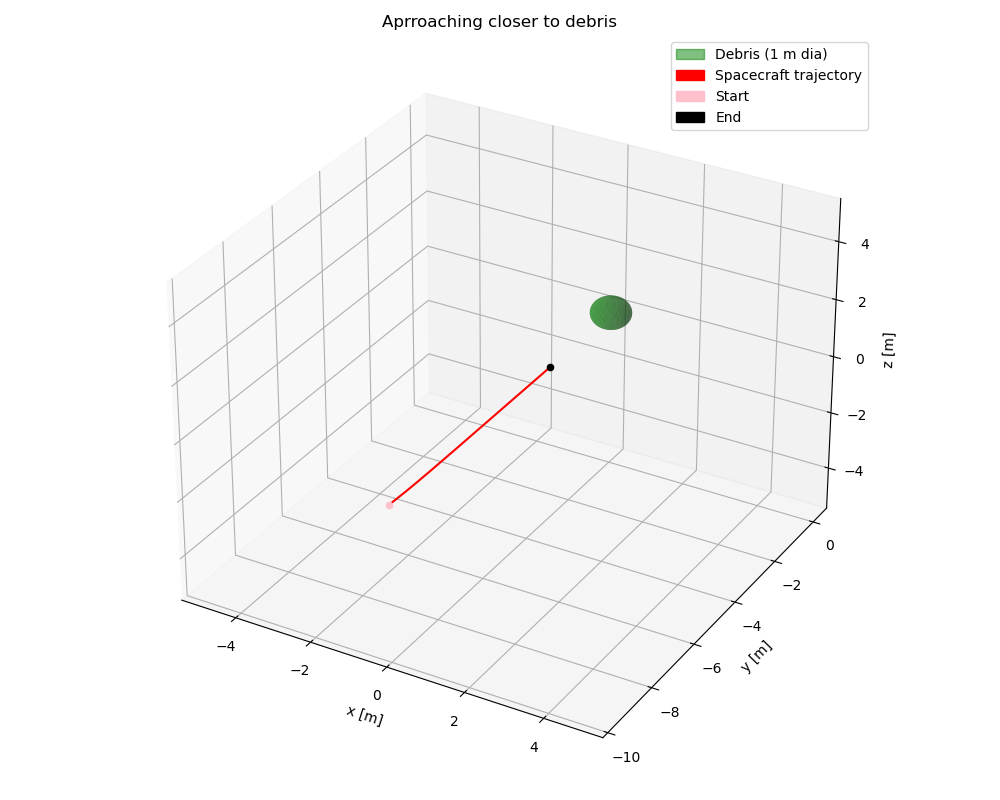

In [911]:
from matplotlib.patches import Patch

xc, yc, zc = x_rk4, y_rk4, z_rk4

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(xc, yc, zc, label='Spacecraft trajectory', color='red')
ax.scatter(xc[0], yc[0], zc[0], color='pink', marker='o', label='Start')
ax.scatter(xc[-1], yc[-1], zc[-1], color='black', marker='o', label='End')

# Plot 3D debris sphere (radius = 0.5 m)
r = 0.5 
u, v = np.linspace(0, 2 * np.pi, 50), np.linspace(0, np.pi, 50)
x_sphere = r * np.outer(np.cos(u), np.sin(v))
y_sphere = r * np.outer(np.sin(u), np.sin(v))
z_sphere = r * np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='green', alpha=0.5)

# Manual legend handle for the debris
legend_elements = [
    Patch(color='green', alpha=0.5, label='Debris (1 m dia)'),
    Patch(color='red', label='Spacecraft trajectory'),
    Patch(color='pink', label='Start'),
    Patch(color='black', label='End')
]

# Labels and formatting
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Aprroaching closer to debris')
ax.grid(True)

# Equal aspect ratio scaling (including space for 2 m debris radius)
all_x = np.append(xc, x_sphere.flatten())
all_y = np.append(yc, y_sphere.flatten())
all_z = np.append(zc, z_sphere.flatten())

x_range = all_x.max() - all_x.min()
y_range = all_y.max() - all_y.min()
z_range = all_z.max() - all_z.min()
max_range = max(x_range, y_range, z_range) / 2.0

mid_x = (all_x.max() + all_x.min()) / 2.0
mid_y = (all_y.max() + all_y.min()) / 2.0
mid_z = (all_z.max() + all_z.min()) / 2.0

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Add manual legend
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


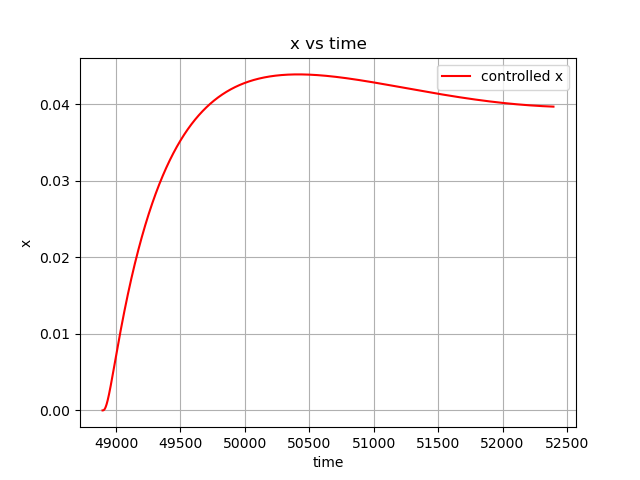

In [912]:
# x

plt.figure()
plt.plot(time, x_rk4, 'red', label='controlled x')

plt.xlabel('time')
plt.ylabel('x')
plt.title('x vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


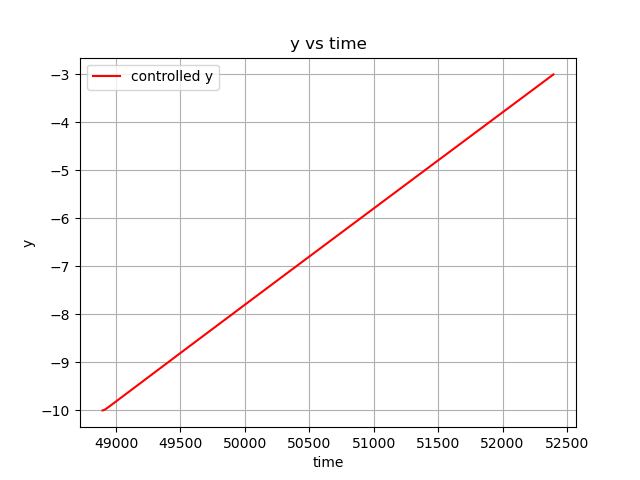

In [913]:
# y

plt.figure()
plt.plot(time, y_rk4, 'red', label='controlled y')

plt.xlabel('time')
plt.ylabel('y')
plt.title('y vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


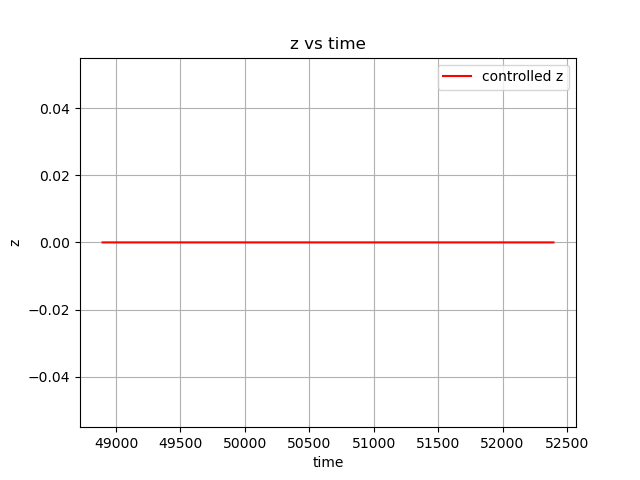

In [914]:
# z

plt.figure()
plt.plot(time, z_rk4, 'red', label='controlled z')

plt.xlabel('time')
plt.ylabel('z')
plt.title('z vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


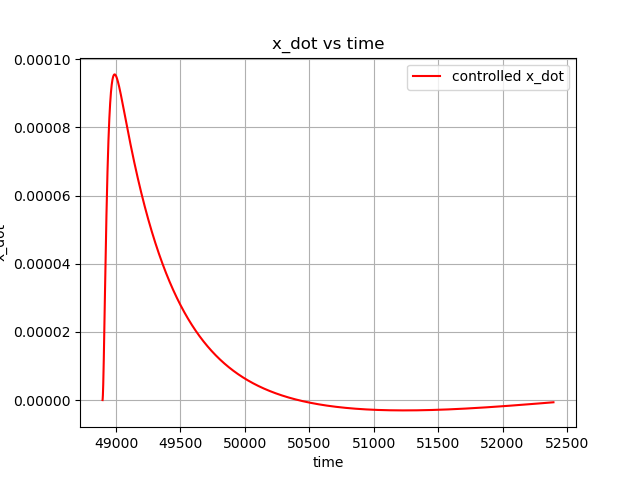

In [915]:
# x_dot

plt.figure()
plt.plot(time, x_dot_rk4, 'red', label='controlled x_dot')

plt.xlabel('time')
plt.ylabel('x_dot')
plt.title('x_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


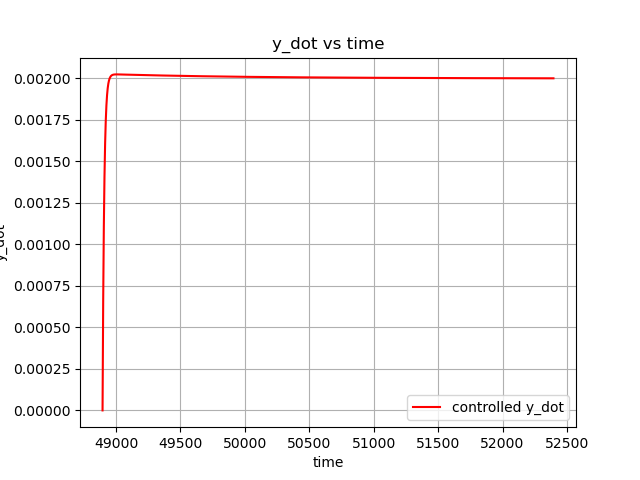

In [916]:
# y_dot

plt.figure()
plt.plot(time, y_dot_rk4, 'red', label='controlled y_dot')

plt.xlabel('time')
plt.ylabel('y_dot')
plt.title('y_dot vs time')
plt.legend()
plt.grid(True)

<IPython.core.display.Javascript object>


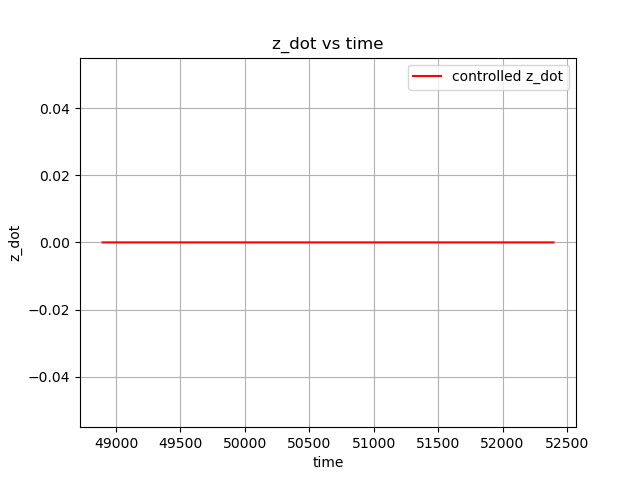

In [917]:
# z_dot

plt.figure()
plt.plot(time, z_dot_rk4, 'red', label='controlled z_dot')

plt.xlabel('time')
plt.ylabel('z_dot')
plt.title('z_dot vs time')
plt.legend()
plt.grid(True)

In [918]:
x_rk4[-1]

0.03971536343493982

In [919]:
y_rk4[-1]

-2.99971050212629

In [920]:
z_rk4[-1]

0.0

In [921]:
x_dot_rk4[-1]

-6.424014472746308e-07

In [922]:
y_dot_rk4[-1]

0.0020001512784137915

In [923]:
z_dot_rk4[-1]

0.0

<IPython.core.display.Javascript object>


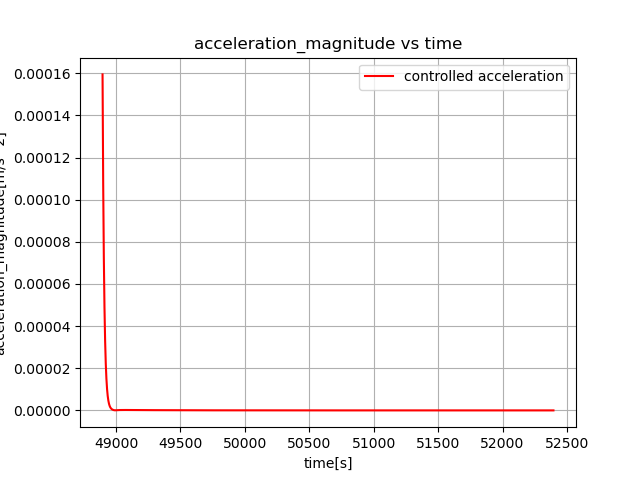

In [924]:
# a_mag

plt.figure()
plt.plot(time[:-1], a_mag, 'red', label='controlled acceleration')


plt.xlabel('time[s]')
plt.ylabel('acceleration_magnitude[m/s^2]')
plt.title('acceleration_magnitude vs time')
plt.legend()
plt.grid(True)

In [925]:
# Fuel cost calculation

# Inputs

a_mag = a_mag          # np.array of acceleration magnitudes [m/s²], one per time step
dt = h                 # time step [s]
Isp = 300              # specific impulse [s]
g0 = 9.80665           # standard gravity [m/s²]
m0 = 191.10378850830267               # initial mass [kg]

# Initialize
mass = [m0]

# Loop through time
F=[]
for a in a_mag:
    m = mass[-1]
    thrust = m * a                             # F = m*a
    mdot = thrust / (Isp * g0)                 # ṁ = F / (Isp * g₀)
    m_new = m - mdot * dt                      # new mass after burning
    mass.append(m_new)
    F.append(thrust)

# Final results

m_final = mass[-1]
delta_m = m0 - m_final

print('initial mass of spacecraft is ',m0 ,'kg')
print('final mass of spacecraft is ',m_final ,'kg')
print('fuel consumed is', delta_m, 'kg')

initial mass of spacecraft is  191.10378850830267 kg
final mass of spacecraft is  191.10364971198965 kg
fuel consumed is 0.00013879631302415874 kg


In [926]:
F.append(6.271e-07) # placeholder

<IPython.core.display.Javascript object>


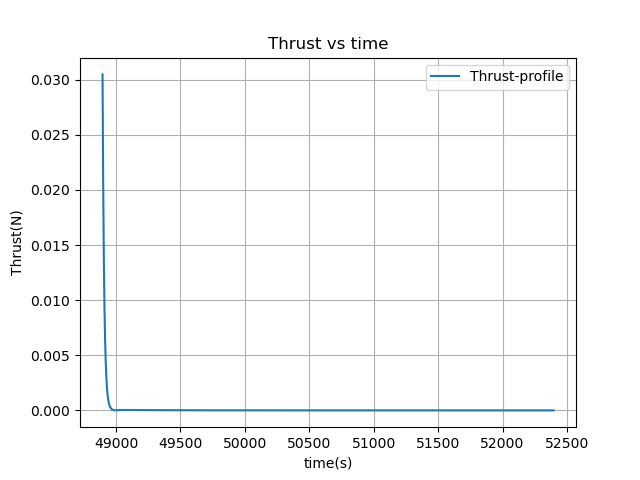

In [927]:
F=np.array(F)

plt.figure()
plt.plot(time, F, label='Thrust-profile')

plt.xlabel('time(s)')
plt.ylabel('Thrust(N)')
plt.title('Thrust vs time')
plt.legend()
plt.grid(True)

In [928]:
# Values for final simulation 

time_propogation = np.arange(43895, 52396, 1)

x = np.hstack((np.zeros(5000), x_rk4[::20]))
y = np.hstack((np.full(5000, -10), y_rk4[::20]))
z = np.hstack((np.zeros(5000), z_rk4[::20]))

x_dot = np.hstack((np.zeros(5000), x_dot_rk4[::20]))
y_dot = np.hstack((np.zeros(5000), y_dot_rk4[::20]))
z_dot = np.hstack((np.zeros(5000), z_dot_rk4[::20]))

vel_mag = np.sqrt(x_dot**2+y_dot**2+z_dot**2)
w_spacecraft_mag = (np.linalg.norm(w_spacecraft, axis=1))[::20]

F = np.hstack((np.zeros(5000), F[::20]))
L = np.linalg.norm(L_spacecraft[::20], axis=1).flatten()

Cd = C_debris[::20]
Cs = C_spacecraft[::20]

In [929]:
time_propogation.shape

(8501,)

In [930]:
x.shape

(8501,)

In [931]:
y.shape

(8501,)

In [932]:
z.shape

(8501,)

In [933]:
x_dot.shape

(8501,)

In [934]:
y_dot.shape

(8501,)

In [935]:
z_dot.shape

(8501,)

In [936]:
vel_mag.shape

(8501,)

In [937]:
F.shape

(8501,)

In [938]:
L.shape

(8501,)

In [939]:
Cd.shape

(8501, 3, 3)

In [940]:
Cs.shape

(8501, 3, 3)

In [941]:
w_spacecraft_mag.shape

(8501,)

<IPython.core.display.Javascript object>


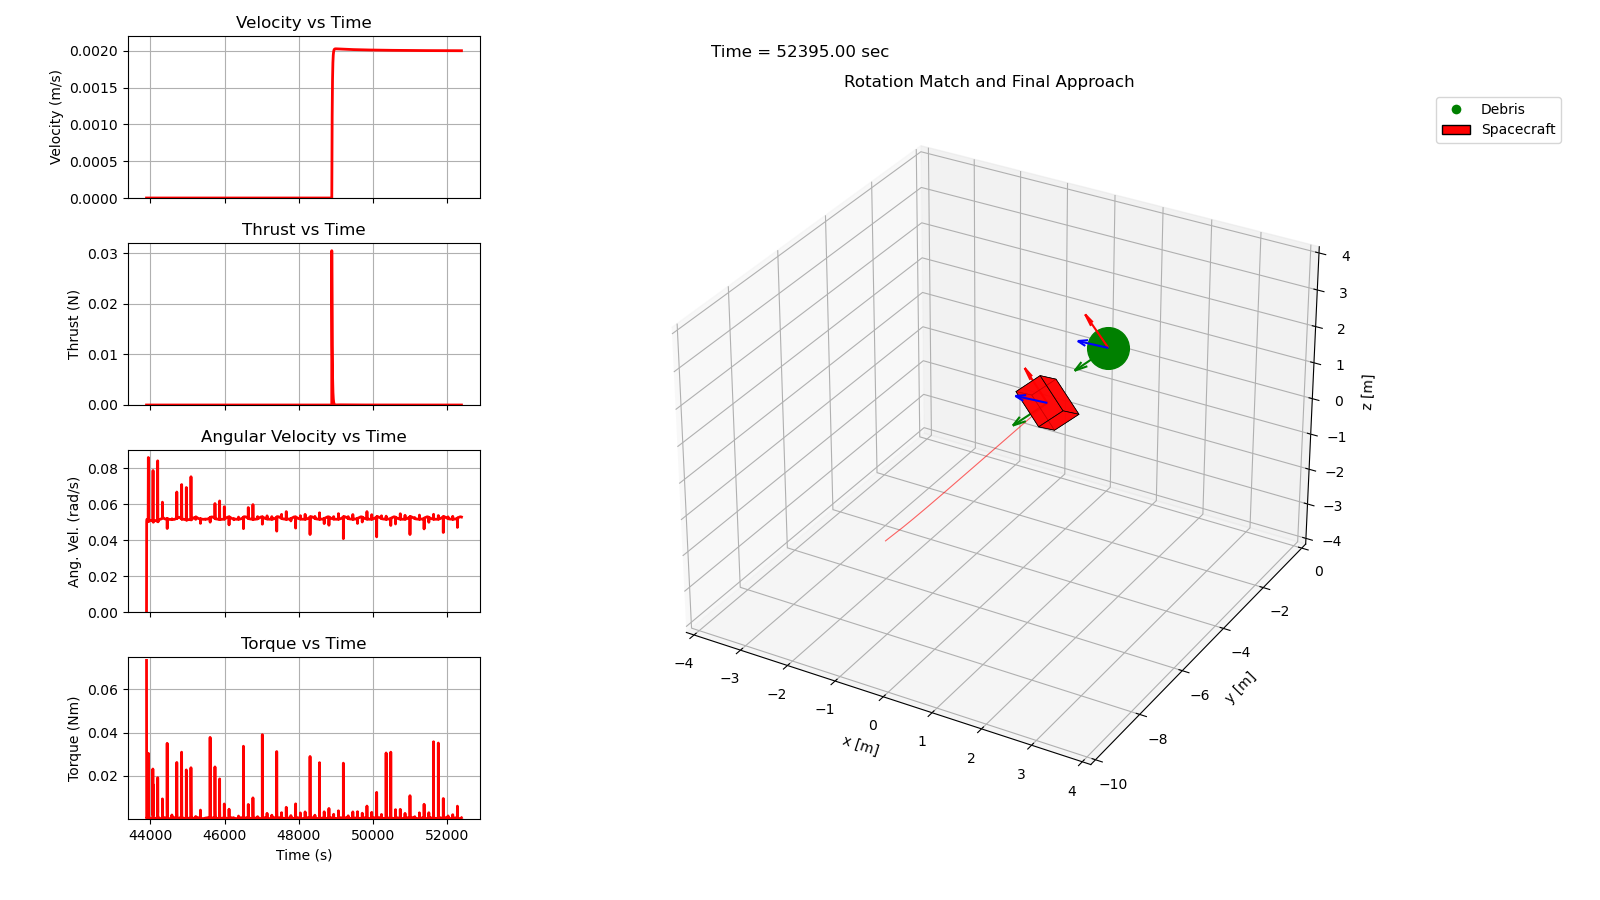

Saved video as 'spacecraft_animation_with_all_plots.mp4'


In [422]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import ipywidgets as widgets
from IPython.display import display
from matplotlib.animation import FFMpegWriter

# --- Your data input here (should already be defined) ---
time = time_propogation
X1 = x
Y1 = y
Z1 = z
thrust = F
velocity = vel_mag
torque = L
angular_velocity = w_spacecraft_mag  
DCM_debris = Cd  # inertial to body
DCM_spacecraft = Cs  # inertial to body

# Ensure arrays are aligned
min_len = min(len(time), len(thrust), len(velocity), len(torque), len(angular_velocity), len(X1))
time = time[:min_len]
thrust = thrust[:min_len]
velocity = velocity[:min_len]
torque = torque[:min_len]
angular_velocity = angular_velocity[:min_len]
X1 = X1[:min_len]
Y1 = Y1[:min_len]
Z1 = Z1[:min_len]
DCM_debris = DCM_debris[:min_len]
DCM_spacecraft = DCM_spacecraft[:min_len]

# --- Set up figure ---
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plot_width = 0.22
plot_height = 0.18
plot_left = 0.08

# --- 2D plots ---
ax_velocity = fig.add_axes([plot_left, 0.78, plot_width, plot_height])
ax_velocity.set_xlim(time[0]-500, time[-1]+500)
ax_velocity.set_ylim(np.min(velocity), 0.0022)
ax_velocity.set_ylabel("Velocity (m/s)")
ax_velocity.set_title("Velocity vs Time")
ax_velocity.grid(True)
velocity_line, = ax_velocity.plot([], [], 'r-', linewidth=2.0)
ax_velocity.tick_params(labelbottom=False)

ax_thrust = fig.add_axes([plot_left, 0.55, plot_width, plot_height])
ax_thrust.set_xlim(time[0]-500, time[-1]+500)
ax_thrust.set_ylim(np.min(thrust), 0.032)
ax_thrust.set_ylabel("Thrust (N)")
ax_thrust.set_title("Thrust vs Time")
ax_thrust.grid(True)
thrust_line, = ax_thrust.plot([], [], 'r-', linewidth=2.0)
ax_thrust.tick_params(labelbottom=False)

ax_angvel = fig.add_axes([plot_left, 0.32, plot_width, plot_height])
ax_angvel.set_xlim(time[0]-500, time[-1]+500)
ax_angvel.set_ylim(np.min(angular_velocity), 0.09)
ax_angvel.set_ylabel("Ang. Vel. (rad/s)")
ax_angvel.set_title("Angular Velocity vs Time")
ax_angvel.grid(True)
angvel_line, = ax_angvel.plot([], [], 'r-', linewidth=2.0)
ax_angvel.tick_params(labelbottom=False)

ax_torque = fig.add_axes([plot_left, 0.09, plot_width, plot_height])
ax_torque.set_xlim(time[0]-500, time[-1]+500)
ax_torque.set_ylim(np.min(torque), 0.075)
ax_torque.set_xlabel("Time (s)")
ax_torque.set_ylabel("Torque (Nm)")
ax_torque.set_title("Torque vs Time")
ax_torque.grid(True)
torque_line, = ax_torque.plot([], [], 'r-', linewidth=2.0)

# --- 3D Plot ---
ax = fig.add_axes([0.32, 0.1, 0.6, 0.8], projection='3d')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title("Rotation Match and Final Approach ", pad=1)
ax.set_xlim(-4, 4)
ax.set_ylim(-10, 0)
ax.set_zlim(-4, 4)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

ax.plot([0], [0], [0], 'go', markersize=30)
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Debris', markerfacecolor='g', markersize=8),
    Patch(facecolor='red', edgecolor='k', label='Spacecraft')
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

trail1, = ax.plot([], [], [], 'r-', linewidth=0.8, alpha=0.6)

quiver_origin = [ax.quiver(0, 0, 0, 0, 0, 0, color=c, length=10, normalize=True) for c in ['r', 'g', 'b']]
quiver_spacecraft = [ax.quiver(0, 0, 0, 0, 0, 0, color=c, length=10, normalize=True) for c in ['r', 'g', 'b']]

title = fig.suptitle('', y=0.95)

# --- Spacecraft cuboid setup ---
sc_vertices = np.array([
    [-0.5, -0.35, -0.25], [-0.5,  0.35, -0.25], [ 0.5,  0.35, -0.25], [ 0.5, -0.35, -0.25],
    [-0.5, -0.35,  0.25], [-0.5,  0.35,  0.25], [ 0.5,  0.35,  0.25], [ 0.5, -0.35,  0.25]
])
faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4], [2, 3, 7, 6], [1, 2, 6, 5], [0, 3, 7, 4]]

spacecraft_box = Poly3DCollection([], facecolors='red', linewidths=0.5, edgecolors='k', alpha=0.8)
ax.add_collection3d(spacecraft_box)

# --- Update Function ---
current_frame = [0]
is_animating = [True]

def update_frame(frame):
    trail1.set_data(X1[:frame+1], Y1[:frame+1])
    trail1.set_3d_properties(Z1[:frame+1])
    thrust_line.set_data(time[:frame+1], thrust[:frame+1])
    velocity_line.set_data(time[:frame+1], velocity[:frame+1])
    angvel_line.set_data(time[:frame+1], angular_velocity[:frame+1])
    torque_line.set_data(time[:frame+1], torque[:frame+1])
    title.set_text(f'Time = {time[frame]:.2f} sec')

    R_debris = DCM_debris[frame].T
    for i in range(3):
        vec = R_debris[:, i]
        quiver_origin[i].remove()
        quiver_origin[i] = ax.quiver(0, 0, 0, *vec, color=['r', 'g', 'b'][i], length=1, normalize=True)

    R_sc = DCM_spacecraft[frame].T
    pos_sc = np.array([X1[frame], Y1[frame], Z1[frame]])
    rotated_vertices = (R_sc @ sc_vertices.T).T + pos_sc
    box_faces = [[rotated_vertices[i] for i in face] for face in faces]
    spacecraft_box.set_verts(box_faces)

    for i in range(3):
        vec = R_sc[:, i]
        quiver_spacecraft[i].remove()
        quiver_spacecraft[i] = ax.quiver(*pos_sc, *vec, color=['r', 'g', 'b'][i], length=1, normalize=True)

    fig.canvas.draw_idle()

def animate(frame):
    current_frame[0] = frame
    slider.value = frame
    update_frame(frame)
    if frame >= len(time) - 1:
        is_animating[0] = False
        toggle_button.value = False

ani = FuncAnimation(fig, animate, frames=len(time), interval=10, blit=False, repeat=False)

# --- UI Controls ---
slider = widgets.IntSlider(value=0, min=0, max=len(time) - 1, step=1,
                           description='Frame:', continuous_update=True, layout=widgets.Layout(width='80%'))

def on_slider_change(change):
    frame = change['new']
    current_frame[0] = frame
    update_frame(frame)

slider.observe(on_slider_change, names='value')

toggle_button = widgets.ToggleButton(value=True, description='⏸ Pause', tooltip='Toggle animation', icon='pause')

def on_toggle(change):
    is_animating[0] = change['new']
    toggle_button.description = '⏸ Pause' if change['new'] else '▶ Play'
    toggle_button.icon = 'pause' if change['new'] else 'play'

toggle_button.observe(on_toggle, names='value')
display(widgets.HBox([toggle_button, slider]))

# --- Save as video ---
fig.set_size_inches(16, 9)
writer = FFMpegWriter(fps=175, metadata=dict(artist='Me'), bitrate=6000)
ani.save("spacecraft_animation_with_all_plots.mp4", writer=writer)
print("Saved video as 'spacecraft_animation_with_all_plots.mp4'")
